# PyCPT version 2.2

This is an example of a PyCPT Version 2 seasonal climate forecasting workflow. This notebook can be adapted to suit your exact needs through modifications of the code. This notebook uses PyCPT v2 utilities to 

1. download data from the IRI Data Library (through the CPT-DL python library) 
2. Run bias-correction using the IRI Climate Predictability Tool (through its companion python library, CPT-CORE) 
3. Plot skills scores and spatial loadings
4. Produce a multi-model ensemble forecast by taking the simple average of the bias-corrected members
5. Plots skill scores, deterministic forecasts, probabilistic forecasts, and exceedance probabilities for this NextGen MME forecast. 

PyCPT Version 2 was primarily designed and implemented by Kyle Hall.

## Function documentation
To get help on a function, e.g. `pycpt.setup`, run the following command in a new cell:
```
pycpt.setup?
```
To see the function's source code, use two question marks instead of one.

#### Imports - This cell imports PyCPTv2 libraries 

In [1]:
import pycpt
import packaging
min_version = '2.2.1'
assert packaging.version.parse(pycpt.__version__) >= packaging.version.parse(min_version), f'This notebook requires version {min_version} or higher of the pycpt library, but you have version {pycpt.__version__}. Please close the notebook, update your environment, and load the notebook again. See https://iri-pycpt.github.io/installation/'

import cptdl as dl 
import datetime as dt
import numpy as np
from pathlib import Path
import xarray as xr

#### Define case directory
The directory where inputs, outputs, and figures generated by this notebook will be stored.

In [2]:
case_dir = Path.home() / "Desktop/PyCPT" / "WAfricaJAS_startJun"

#### Parameters - This cell defines the parameters of your CPT analysis

In [3]:
MOS = 'CCA' # must be one of 'CCA', 'PCR', or "None"
predictor_names = [ "SPEAR.PRCP", "CCSM4.PRCP", "CanSIPSIC3.PRCP","CFSv2.PRCP","GEOSS2S.PRCP"]# ['CFSv2.PRCP','SEAS5.PRCP']
predictand_name = 'UCSB.PRCP'

#predictor_names = ['SPEAR.TMAX','CanSIPSIC3.TMAX']
#predictand_name = 'UCSB.TMAX'

# use dl.observations.keys() to see all options for predictand 
# and dl.hindcasts.keys() to see all options for predictors
# make sure your first_year & final_year are compatible with 
# your selections for your predictors and predictands 

download_args = { 
   # 'fdate':
   #   the initialization date of the model forecasts / hindcasts
   #   this field is defined by a python datetime.datetime object
   #   for example: dt.datetime(2022, 5, 1) # YYYY, MM, DD as integers
   #   The year field is only used for forecasts, otherwise ignored
   #   The day field is only used in subseasonal forecasts, otherwise ignored
   #   The month field is an integer representing a month - ie, May=5
  'fdate':  dt.datetime(2023, 2, 1), #dt.datetime(2022, 6, 1),  
    
   # 'first_year':
   #   the first year of hindcasts you want. **NOT ALL MODELS HAVE ALL YEARS**
   #   double check that your model has hindcast data for all years in [first_year, final_year]
   #   This field is defined by a python integer representing a year, ie: 1993
  'first_year': 1991,  
    
   # 'final_year':
   #   the final year of hindcasts you want. **NOT ALL MODELS HAVE ALL YEARS**
   #   double check that your model has hindcast data for all years in [first_year, final_year]
   #   This field is defined by a python integer representing a year, ie: 2016
  'final_year': 2020,  
    
   # 'predictor_extent':
   #   The geographic bounding box of the climate model data you want to download
   #   This field is defined by a python dictionary with the keys "north", "south",
   #   "east", and "west", each of which maps to a python integer representing the 
   #   edge of a bounding box. i.e., "north" will be the northernmost boundary,
   #   "south" the southernmost boundary. Example: {"north": 90, "south": 90, "east": 0, "west": 180}
  'predictor_extent': {
    'east':  -67, #20,
    'west': -78, #-20, 
    'north': -18, #20,
    'south': -57 #0 
  }, 
    
   # 'predictand_extent':
   #   The geographic bounding box of the observation data you want to download
   #   This field is defined by a python dictionary with the keys "north", "south",
   #   "east", and "west", each of which maps to a python integer representing the 
   #   edge of a bounding box. i.e., "north" will be the northernmost boundary,
   #   "south" the southernmost boundary. Example: {"north": 90, "south": 90, "east": 0, "west": 180}
  'predictand_extent': {
    'east':  -67, #10, 
    'west': -78, #-18,  
    'north': -18, #18,  
    'south': -57 #3 
  },

    
   # 'lead_low': 
   #   the number of months from the first of the initialization month to the center of 
   #   the first month included in the target period. Always an integer + 0.5. 
   #   this field is defined by a python floating point number 
   #   for example  a lead-1 forecast would use lead_low=1.5, if you want init=may, target=Jun-..
  'lead_low': 1.5,
    
   # 'lead_high': 
   #   the number of months from the first of the initialization month to the center of 
   #   the last month included in the target period. Always an integer + 0.5. 
   #   this field is defined by a python floating point number 
   #   for example  a forecast initialized in may, whose target period ended in Aug, 
   #   would use lead_high=3.5
  'lead_high': 3.5, 
    
   # 'target': 
   #   Mmm-Mmm indicating the months included in the target period of the forecast. 
   #   this field is defined by a python string, with two three-letter month name abbreviations 
   #   whose first letters are capitalized, and all other letters are lowercase
   #   and who are separated by a dash character. 
   #   for example, if you wanted a JJA target period, you would use 'Jun-Aug'
  'target': 'Mar-May',#'Jul-Sep',
    
   # 'filetype':
   #   the filetype to be downloaded. for now, it saves a lot of headache just to set this equal
   #   to 'cptv10.tsv' which is a boutique plain-text CPT filetype based on .tsv + metadata
  'filetype': 'cptv10.tsv'
}

cpt_args = { 
    'transform_predictand': None,  # transformation to apply to the predictand dataset - None, 'Empirical', 'Gamma'
    'tailoring': None,  # tailoring None, 'Anomaly'
    'cca_modes': (1,3), # minimum and maximum of allowed CCA modes 
    'x_eof_modes': (1,8), # minimum and maximum of allowed X Principal Componenets 
    'y_eof_modes': (1,6), # minimum and maximum of allowed Y Principal Components 
    'validation': 'crossvalidation', # the type of validation to use - crossvalidation, retroactive, or doublecrossvalidation
    'drymask': False, #whether or not to use a drymask of -999
    'scree': True, # whether or not to save % explained variance for eof modes
    'crossvalidation_window': 5,  # number of samples to leave out in each cross-validation step 
    'synchronous_predictors': True, # whether or not we are using 'synchronous predictors'
}


force_download = True

In [4]:
domain_dir = pycpt.setup(case_dir, download_args["predictor_extent"])

Input data will be saved in /Users/xandre/Desktop/PyCPT/WAfricaJAS_startJun/-78W--67E_to_-57S--18N/data
Figures will be saved in /Users/xandre/Desktop/PyCPT/WAfricaJAS_startJun/-78W--67E_to_-57S--18N/figures
Output will be saved in /Users/xandre/Desktop/PyCPT/WAfricaJAS_startJun/-78W--67E_to_-57S--18N/output


In [5]:
# Uncomment the following line & change the config filepath to save this configuration: 
config_file = pycpt.save_configuration(case_dir / 'config', download_args, cpt_args, MOS, predictor_names, predictand_name )
print("Saved configuration to", config_file)

# Uncomment the following line & change the config filepath to load an existing configuration: 
#MOS, download_args, cpt_args, predictor_names, predictand_name = pycpt.load_configuration('test1.config')

Saved configuration to /Users/xandre/Desktop/PyCPT/WAfricaJAS_startJun/config


#### Visualize predictor and predictand domains

/Users/xandre/opt/anaconda3/envs/pycpt_environment/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/xandre/opt/anaconda3/envs/pycpt_environment/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


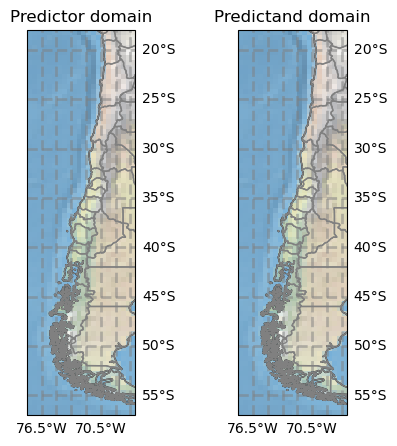

In [6]:
pycpt.plot_domains(download_args['predictor_extent'], download_args['predictand_extent'])

#### Download Observations, Hindcasts, and Forecasts from IRI Data Library

In [7]:
Y, hindcast_data, forecast_data = pycpt.download_data(predictand_name, predictor_names, download_args, domain_dir, force_download)

{'fdate': datetime.datetime(2023, 2, 1, 0, 0), 'first_year': 1991, 'final_year': 2020, 'predictor_extent': {'east': -67, 'west': -78, 'north': -18, 'south': -57}, 'predictand_extent': {'east': -67, 'west': -78, 'north': -18, 'south': -57}, 'lead_low': 1.5, 'lead_high': 3.5, 'target': 'Mar-May', 'filetype': 'cptv10.tsv'}
{'fdate': datetime.datetime(2023, 2, 1, 0, 0), 'first_year': 1991, 'final_year': 2020, 'predictor_extent': {'east': -67, 'west': -78, 'north': -18, 'south': -57}, 'predictand_extent': {'east': -67, 'west': -78, 'north': -18, 'south': -57}, 'lead_low': 1.5, 'lead_high': 3.5, 'target': 'Mar-May', 'filetype': 'cptv10.tsv'}
URL: https://iridl.ldeo.columbia.edu/SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p25/.prcp/92/mul/T/(1%20Jan%201991)/(31%20Dec%202020)/RANGE/T/%28Mar-May%201991-2020%29/seasonalAverage/Y/%28-57%29/%28-18%29/RANGEEDGES/X/%28-78%29/%28-67%29/RANGEEDGES/-999/setmissing_value/%5BX/Y%5D%5BT%5Dcptv10.tsv

DOWNLOADING: [*************************] (243

#### Perform CPT Analysis
Set `interactive = True` to see detailed output from CPT.

In [8]:
interactive = False

In [9]:
hcsts, fcsts, skill, pxs, pys = pycpt.evaluate_models(hindcast_data, MOS, Y, forecast_data, cpt_args, domain_dir, predictor_names, interactive)

#### Plot skill of individual models

Deterministic skill metrics:
- pearson
- spearman
- two_alternative_forced_choice
- roc_area_below_normal (Area under ROC curve for Below Normal category)
- roc_area_above_normal (Area under ROC curve for Above Normal category)

Probabilistic skill metrics (in sample):
- generalized_roc
- rank_probability_skill_score

In [10]:
skill_metrics = [
    "pearson",
    "spearman",
    "two_alternative_forced_choice",
    "roc_area_below_normal",
    "roc_area_above_normal",
]

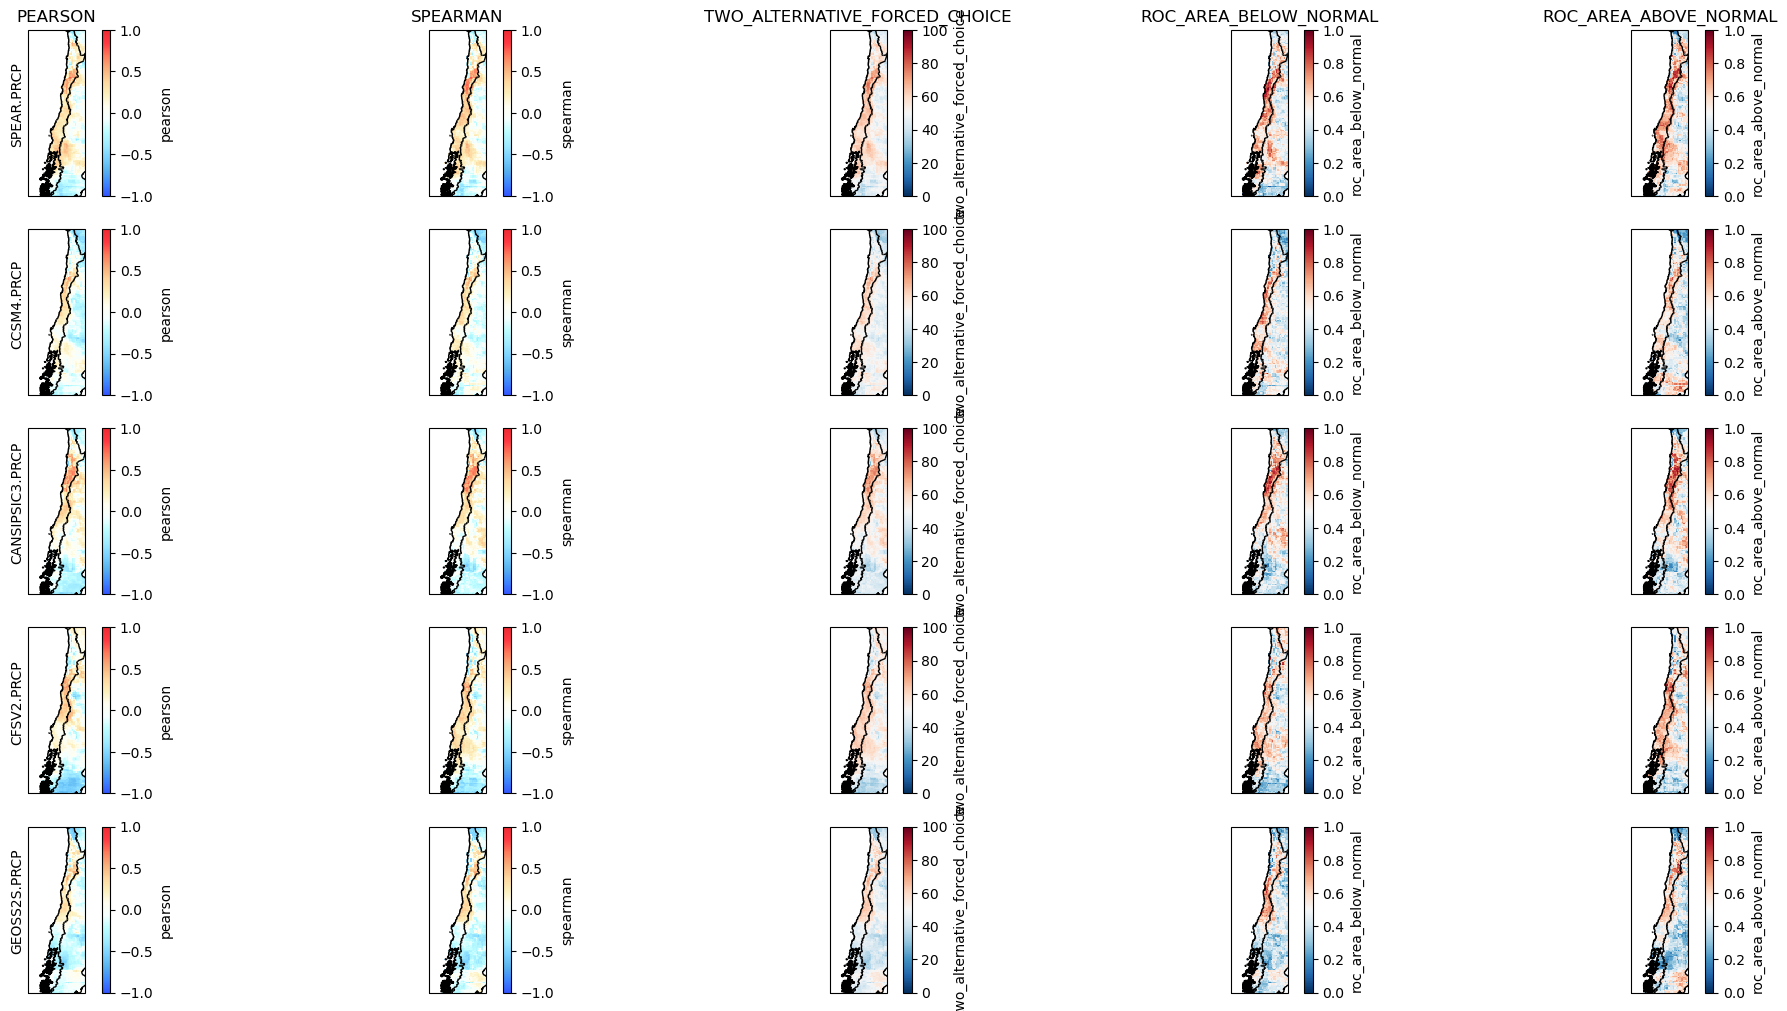

In [11]:
pycpt.plot_skill(predictor_names, skill, MOS, domain_dir, skill_metrics)

#### Plot EOF Modes

SPEAR.PRCP: EOF 1


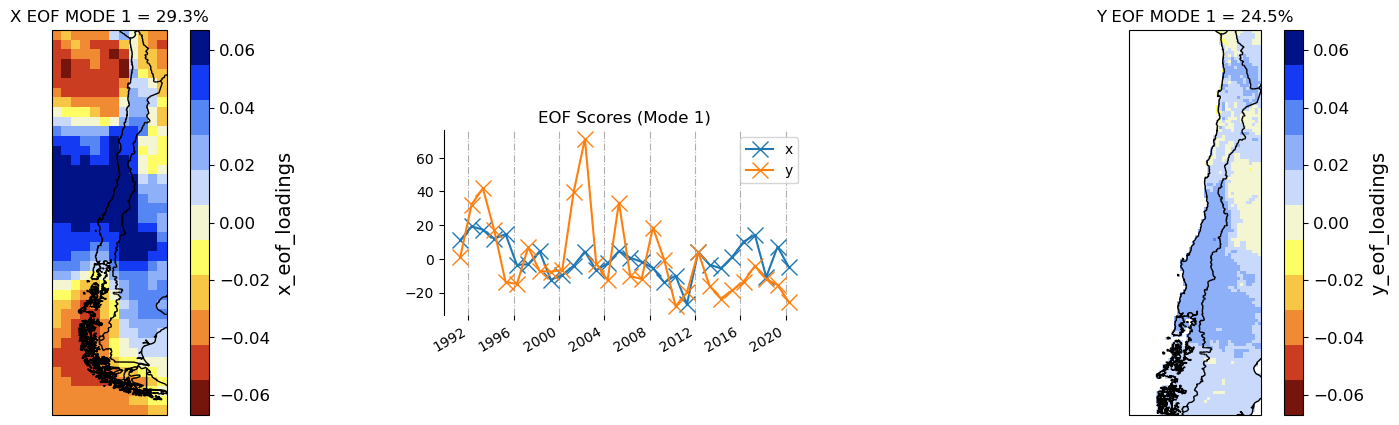

SPEAR.PRCP: EOF 2


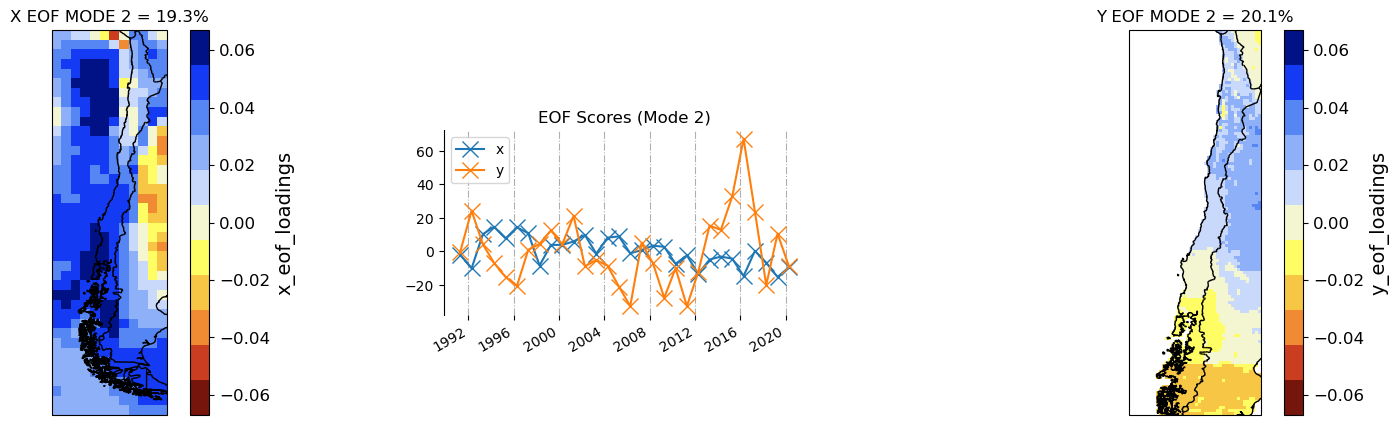

SPEAR.PRCP: EOF 3


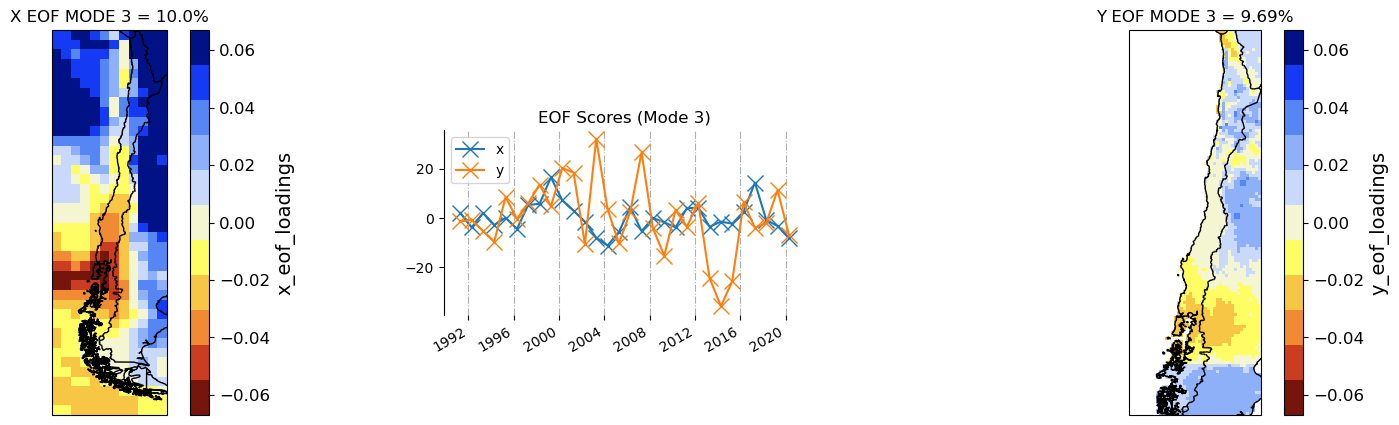

SPEAR.PRCP: EOF 4


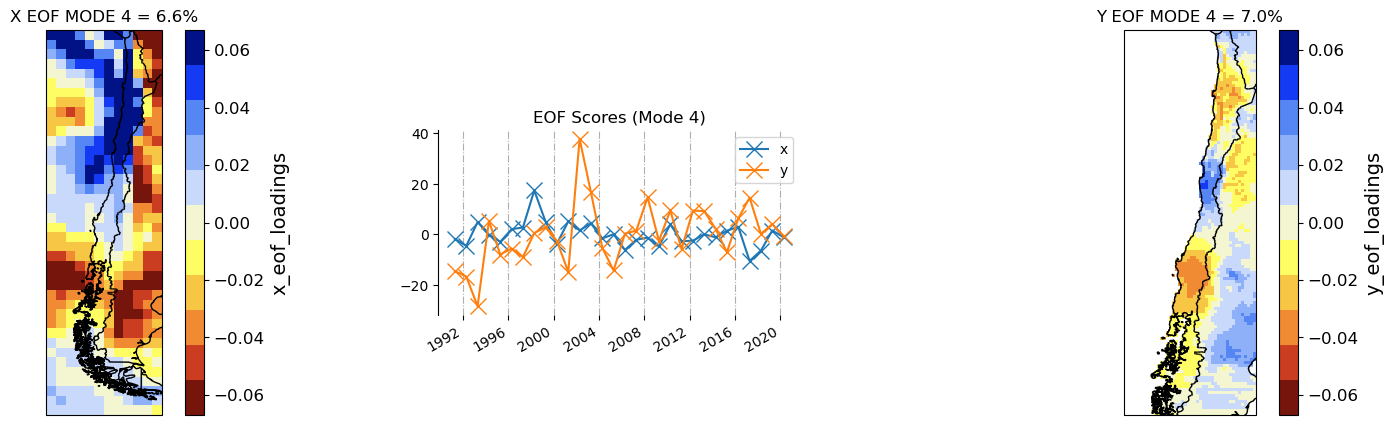

SPEAR.PRCP: EOF 5


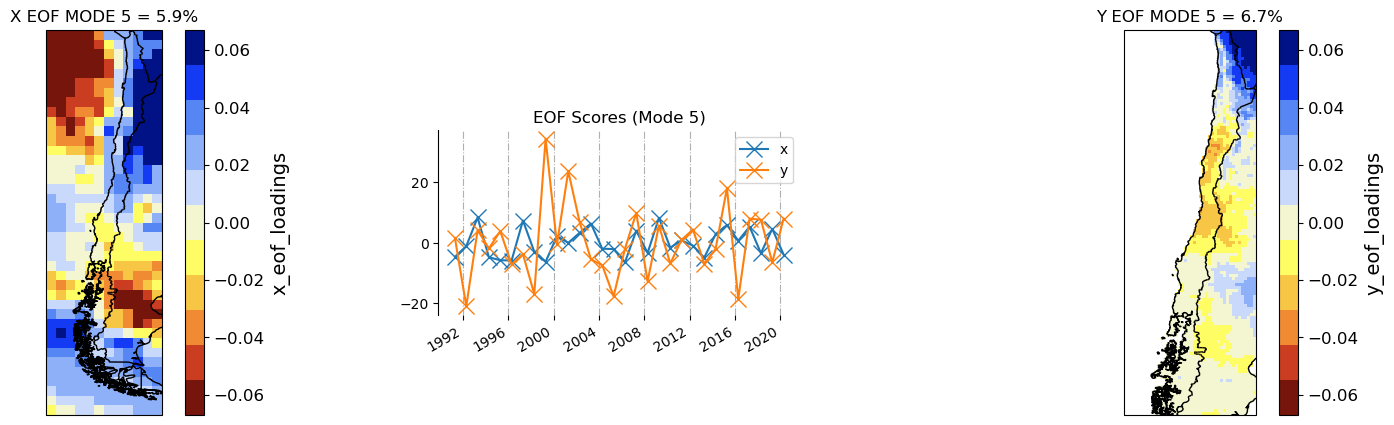

CCSM4.PRCP: EOF 1


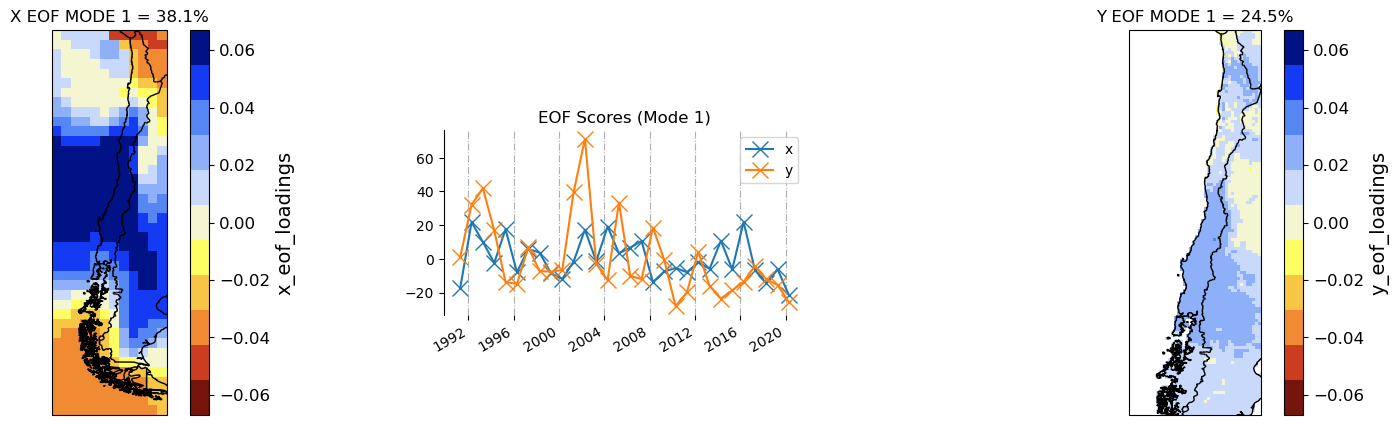

CCSM4.PRCP: EOF 2


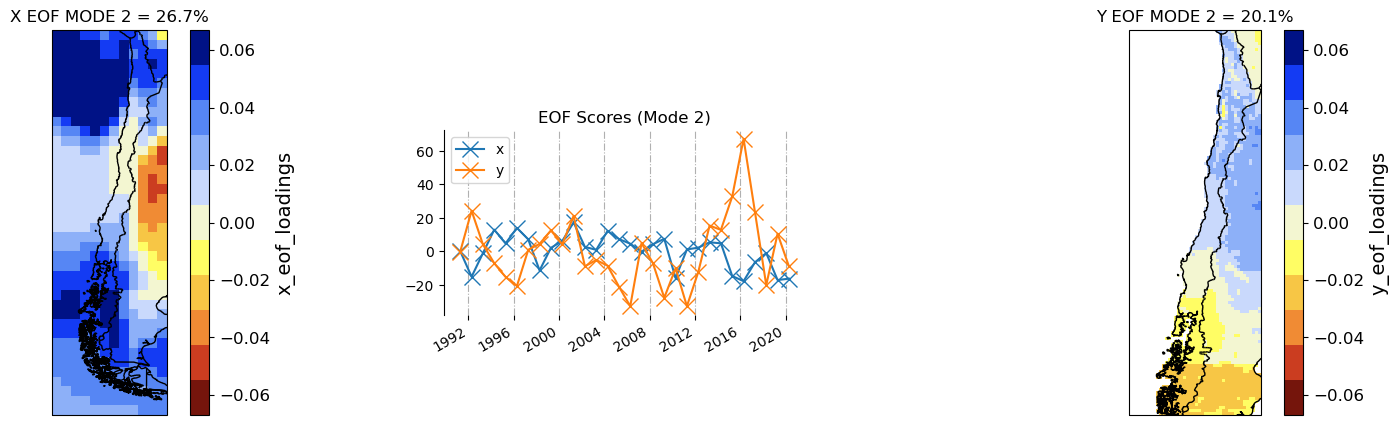

CCSM4.PRCP: EOF 3


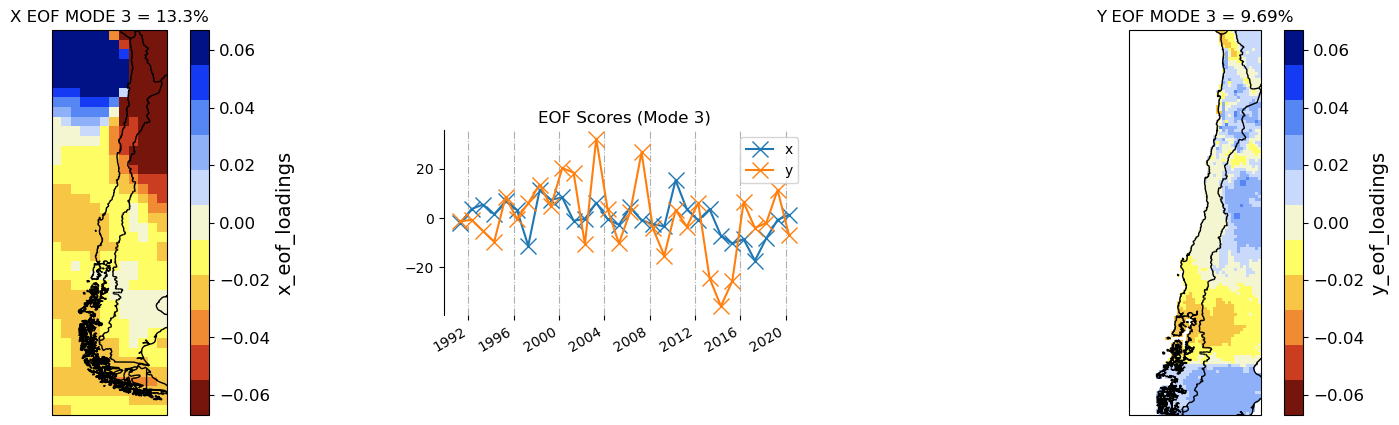

CCSM4.PRCP: EOF 4


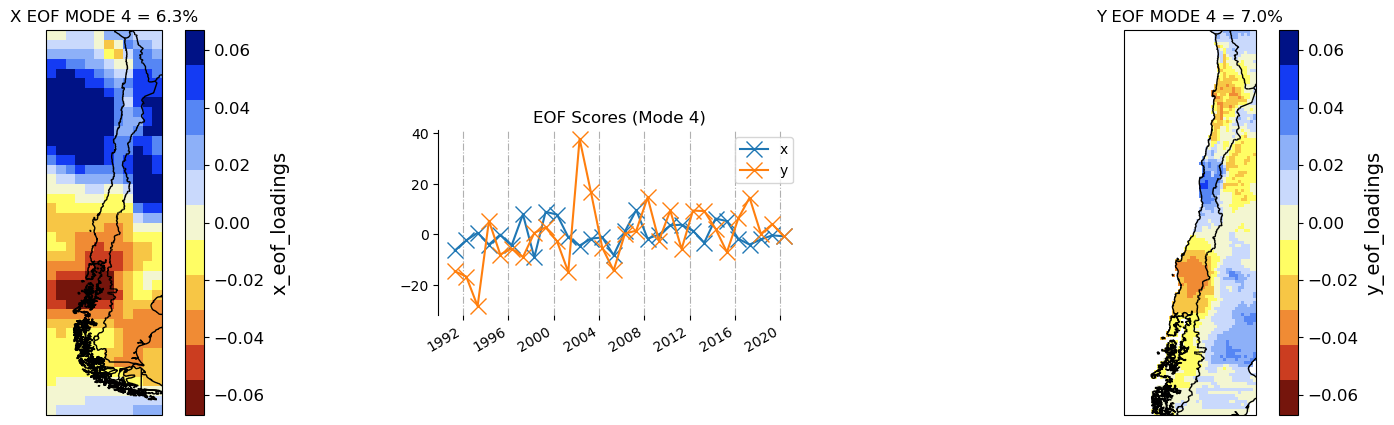

CCSM4.PRCP: EOF 5


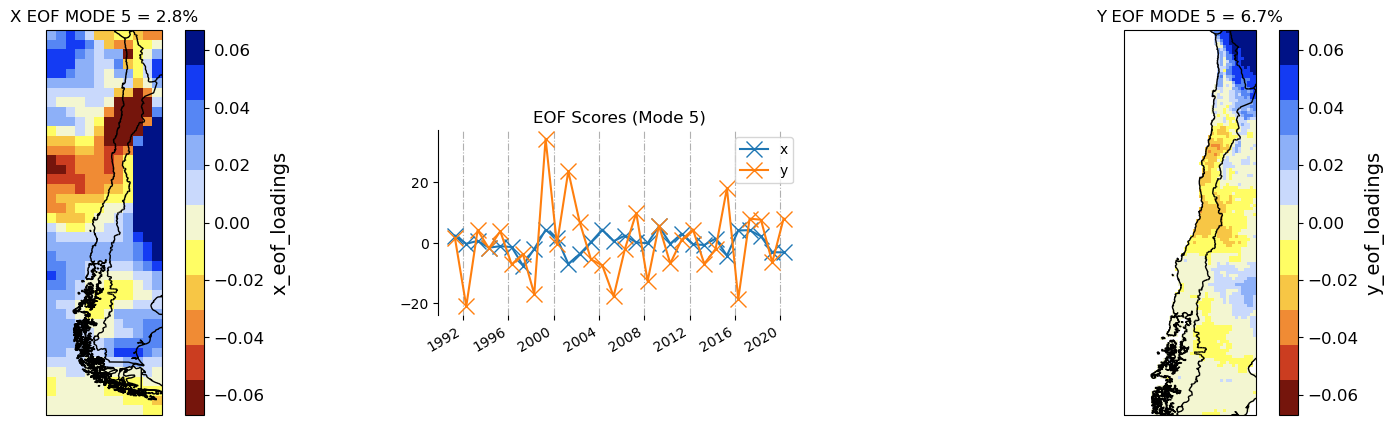

CANSIPSIC3.PRCP: EOF 1


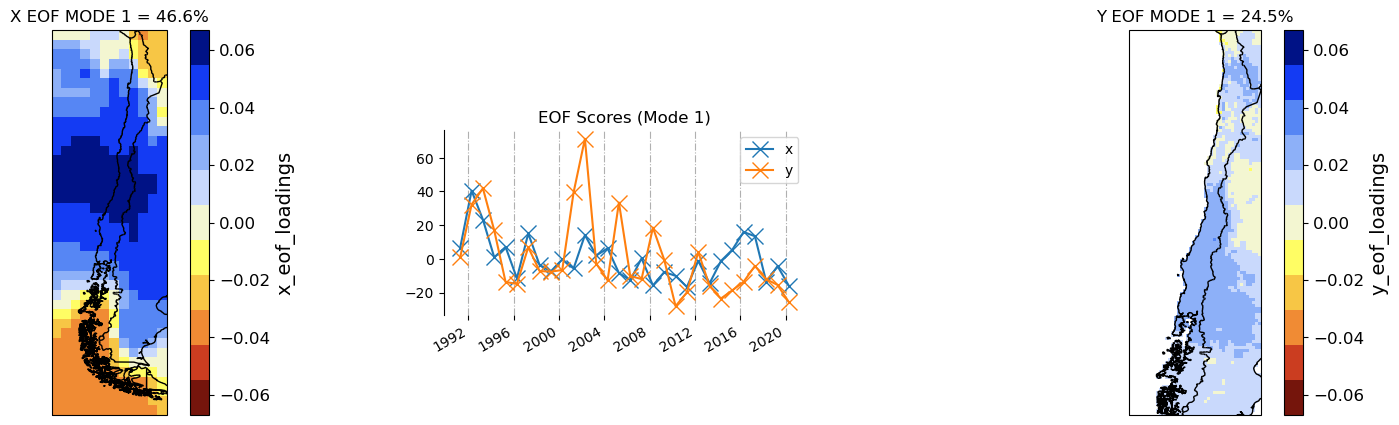

CANSIPSIC3.PRCP: EOF 2


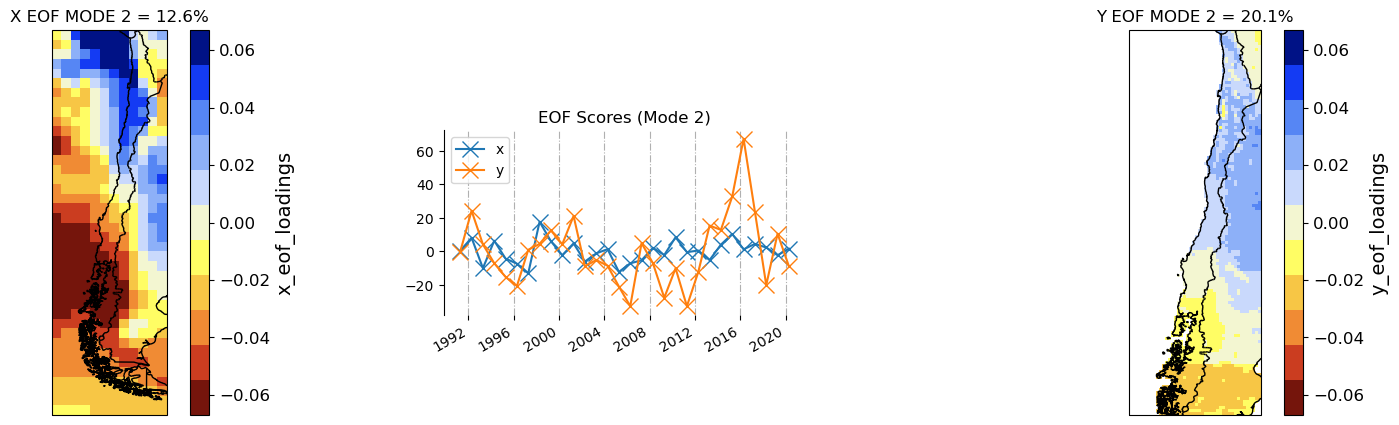

CANSIPSIC3.PRCP: EOF 3


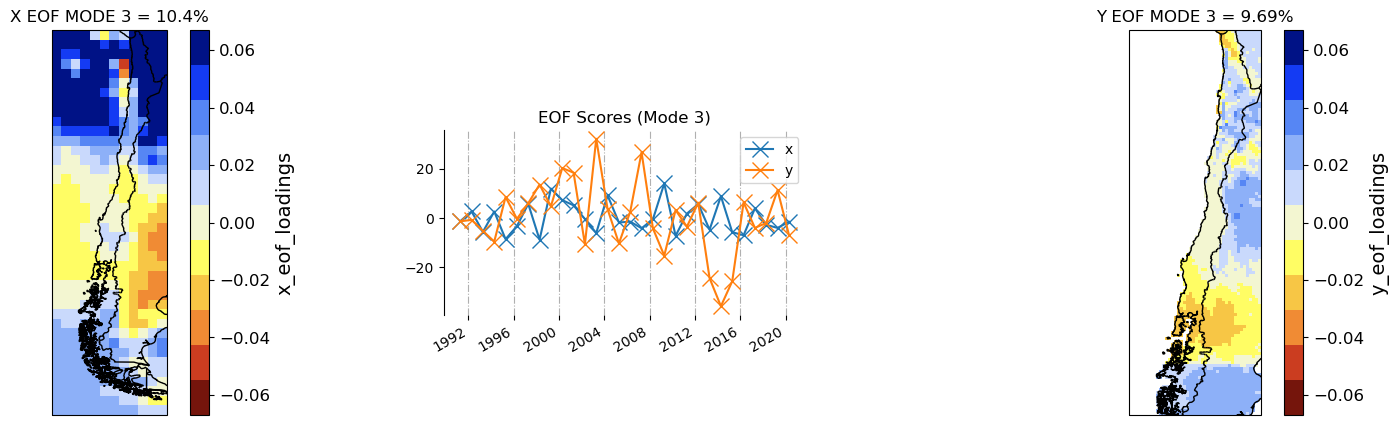

CANSIPSIC3.PRCP: EOF 4


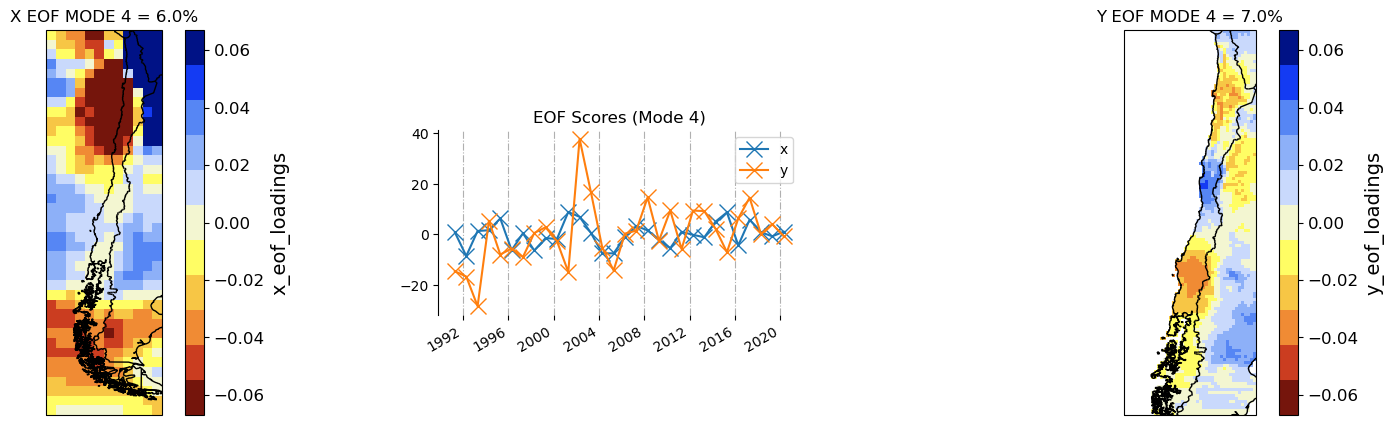

CANSIPSIC3.PRCP: EOF 5


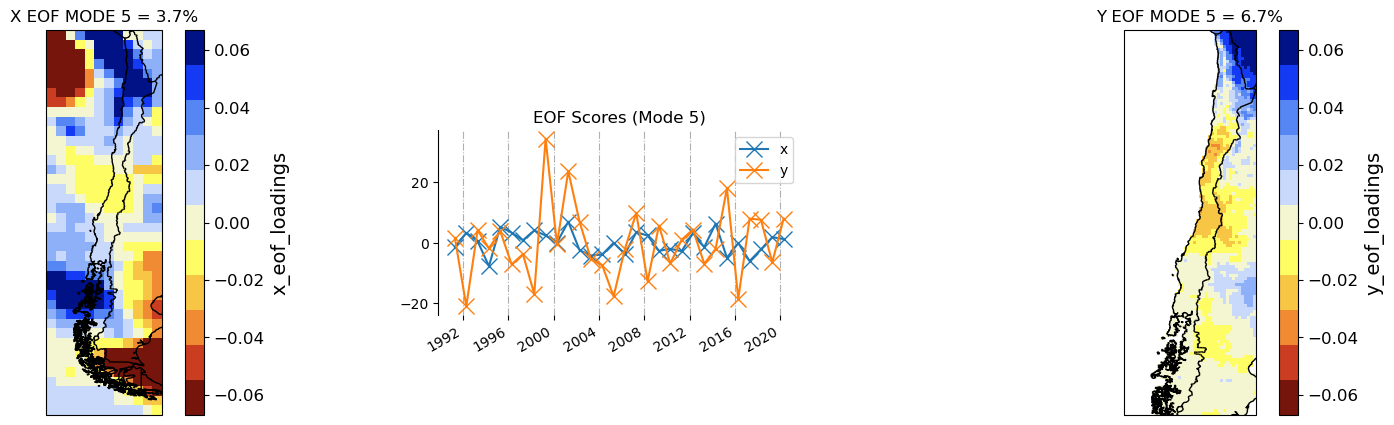

CFSV2.PRCP: EOF 1


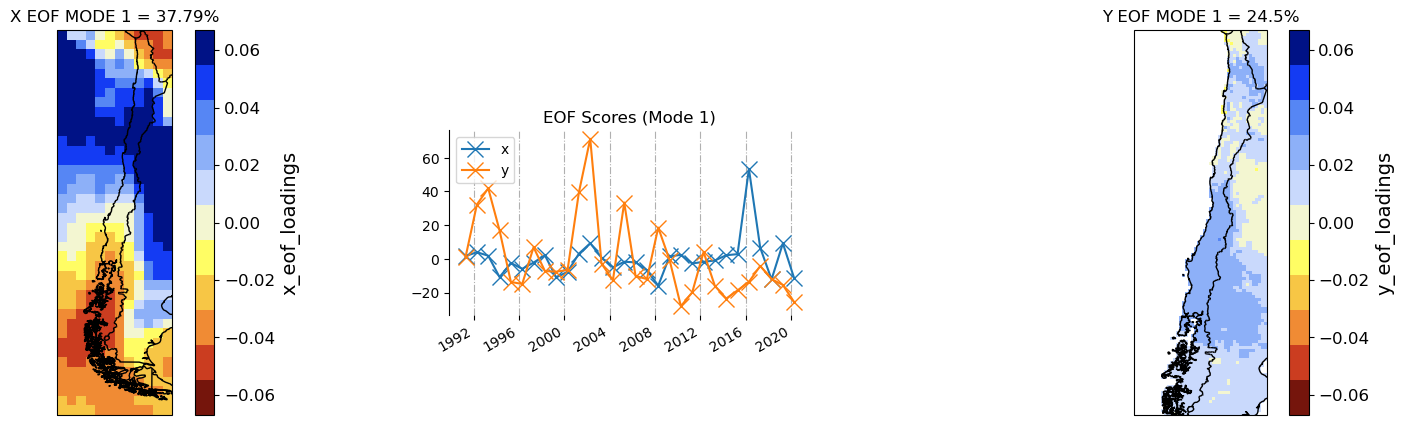

CFSV2.PRCP: EOF 2


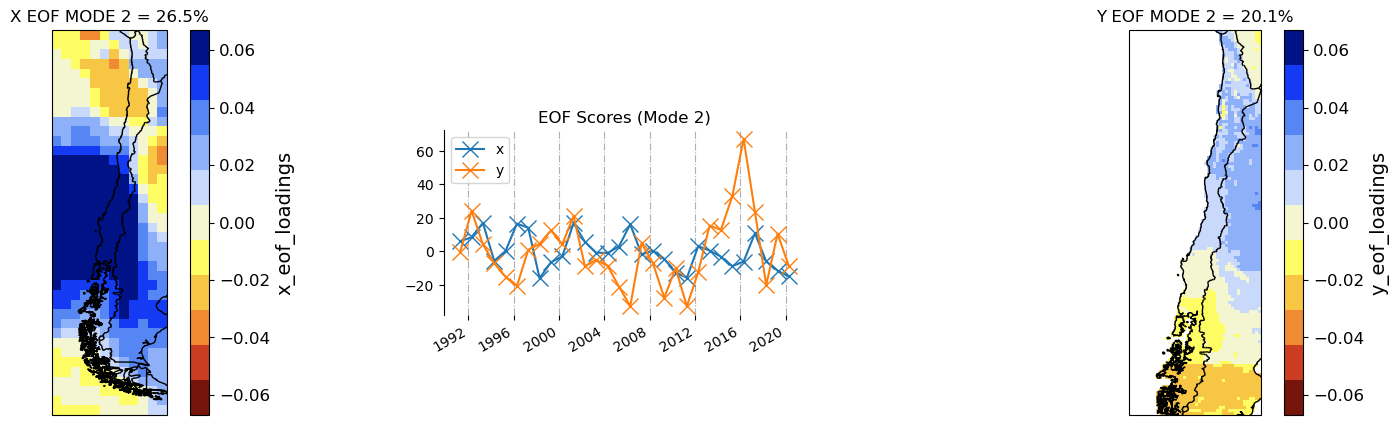

CFSV2.PRCP: EOF 3


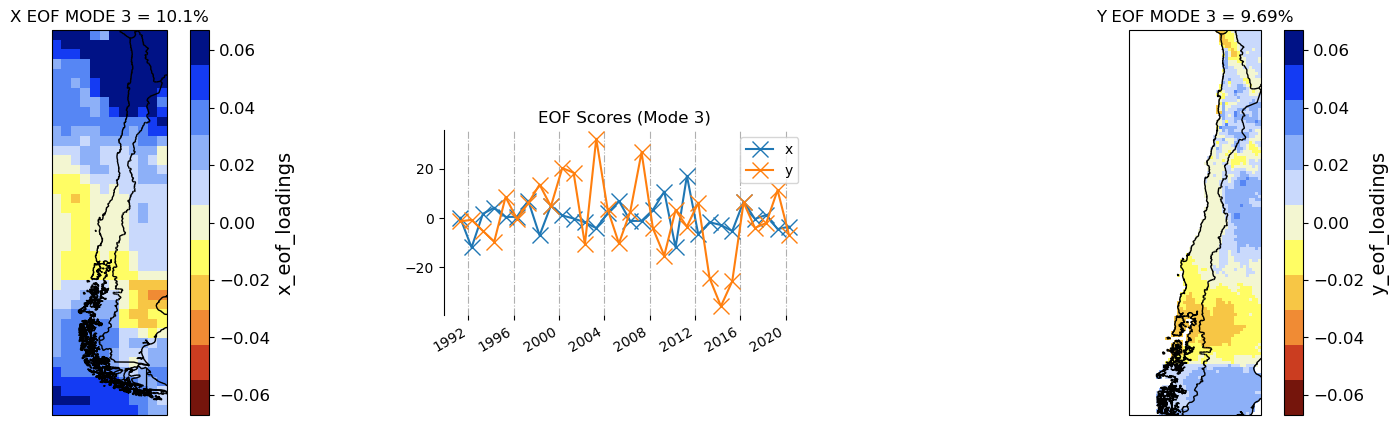

CFSV2.PRCP: EOF 4


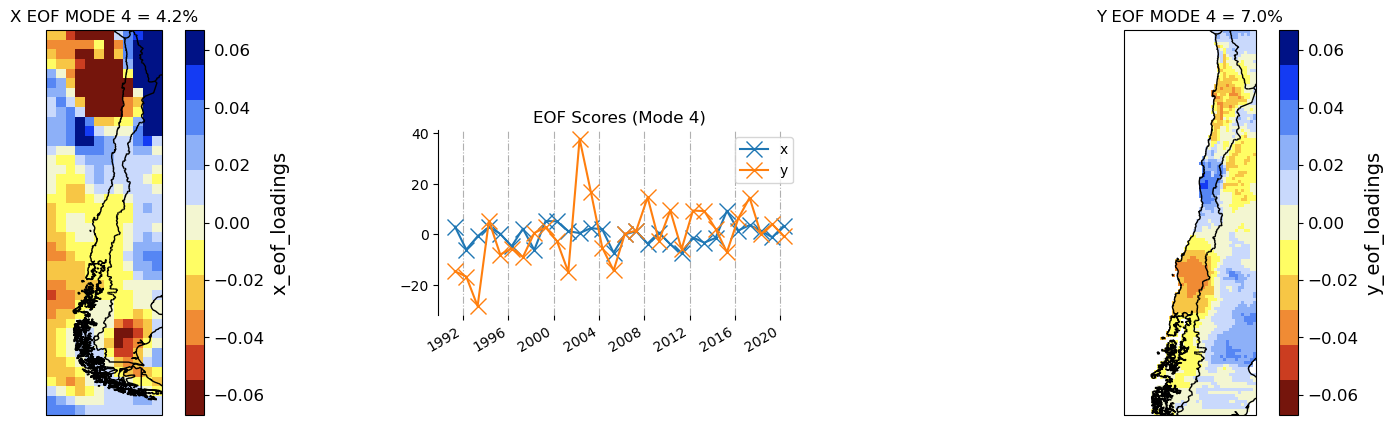

CFSV2.PRCP: EOF 5


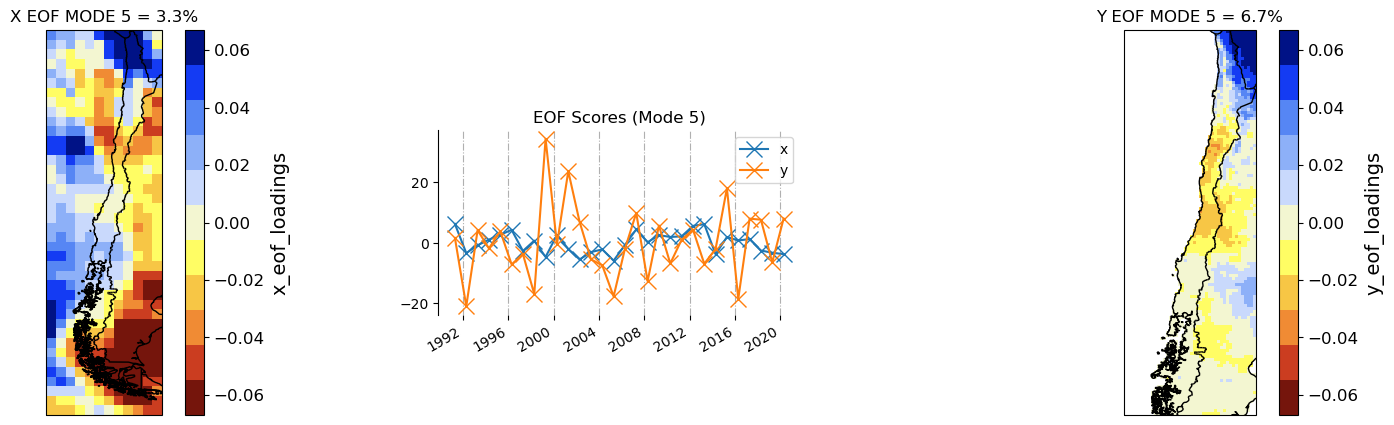

GEOSS2S.PRCP: EOF 1


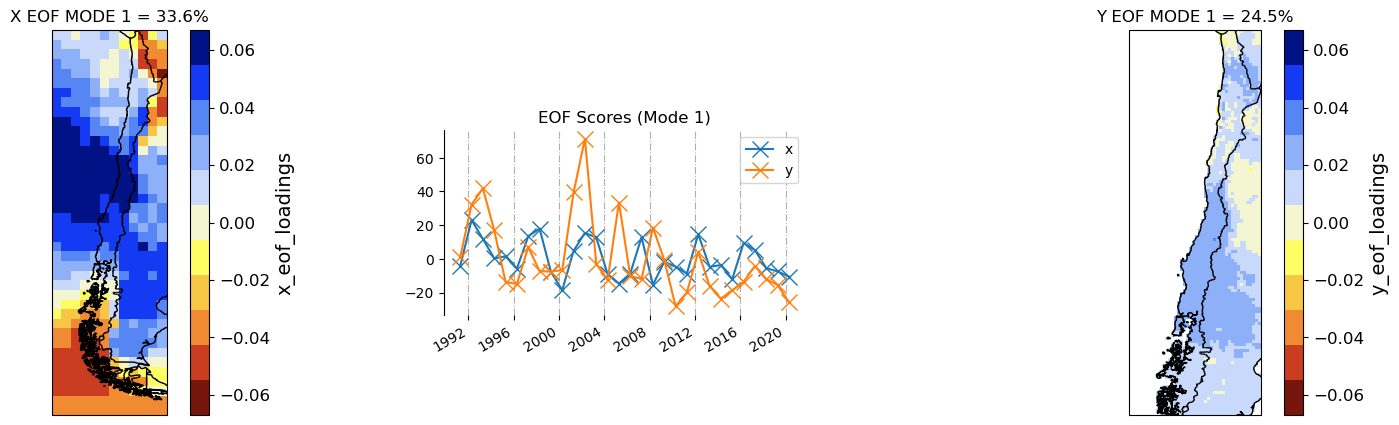

GEOSS2S.PRCP: EOF 2


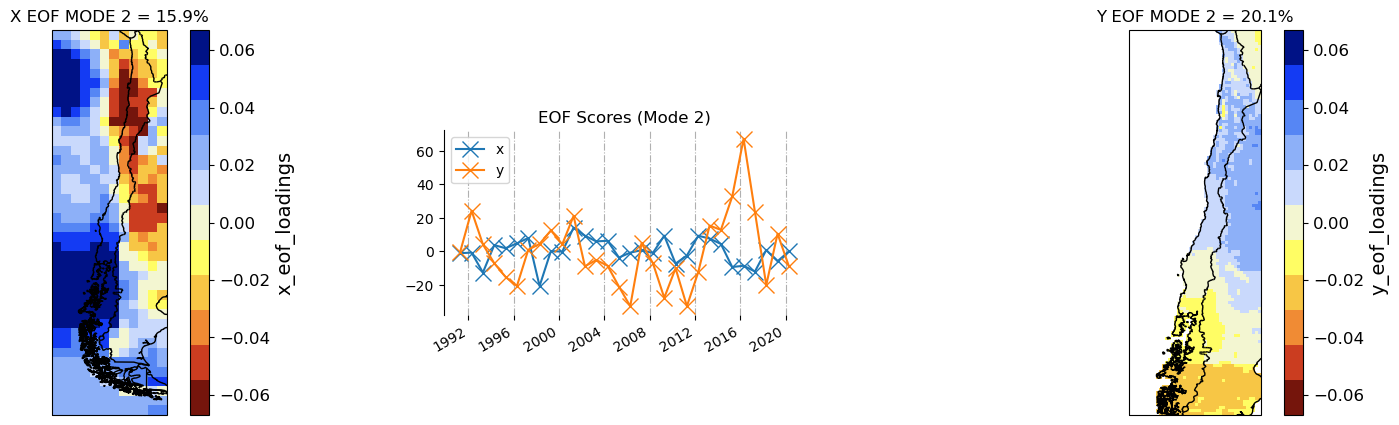

GEOSS2S.PRCP: EOF 3


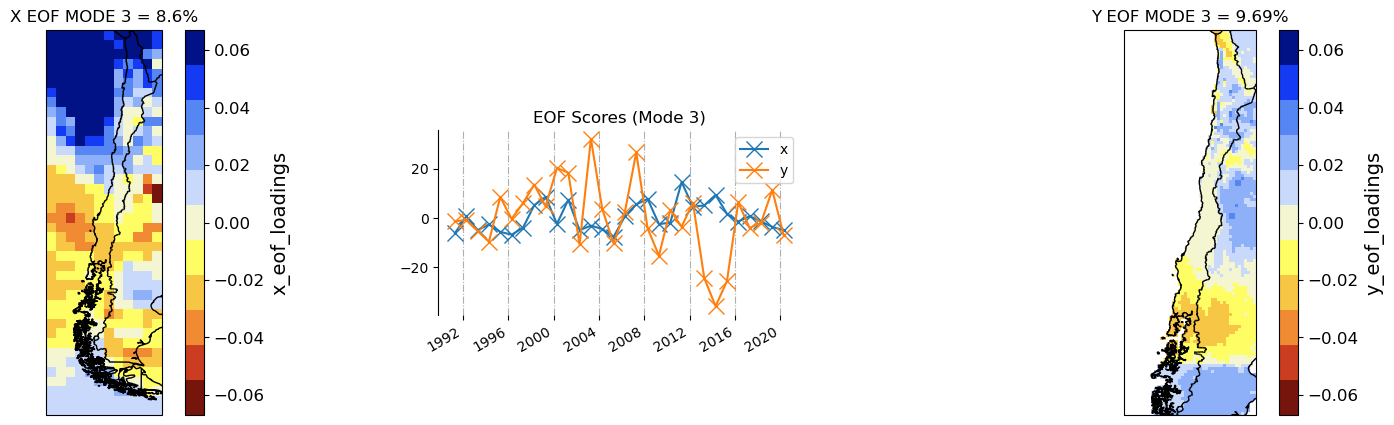

GEOSS2S.PRCP: EOF 4


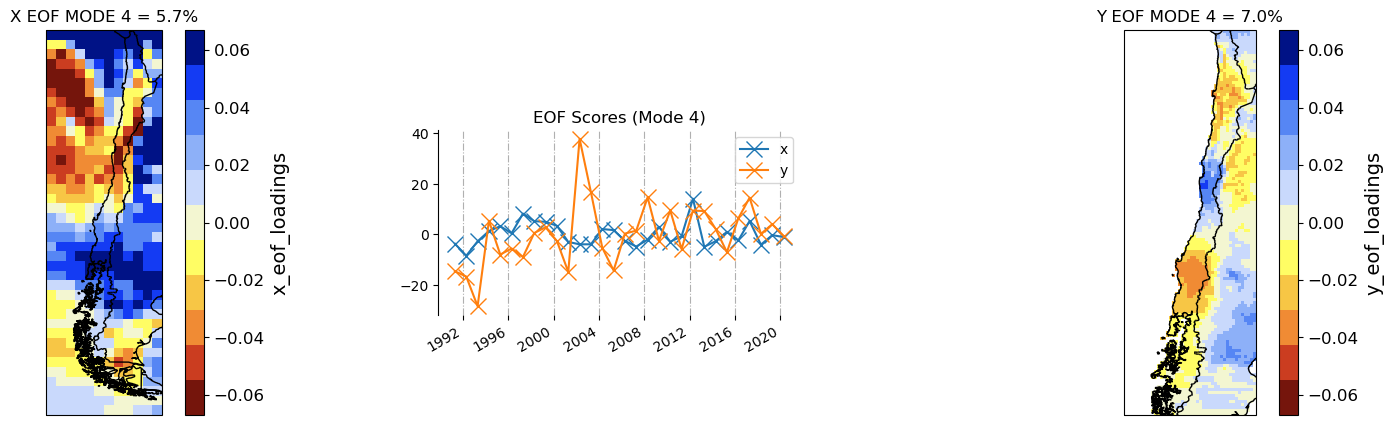

GEOSS2S.PRCP: EOF 5


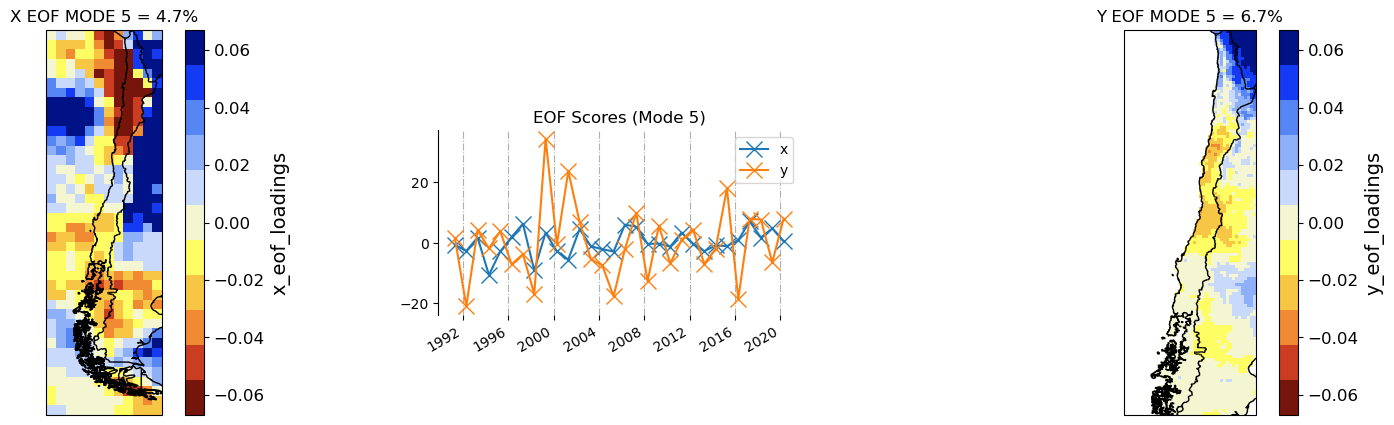

In [12]:
pycpt.plot_eof_modes(MOS, predictor_names, pxs, pys, domain_dir)

#### Plot CCA Modes

SPEAR.PRCP: CCA MODE 1 - Canonical Correlation = 0.73


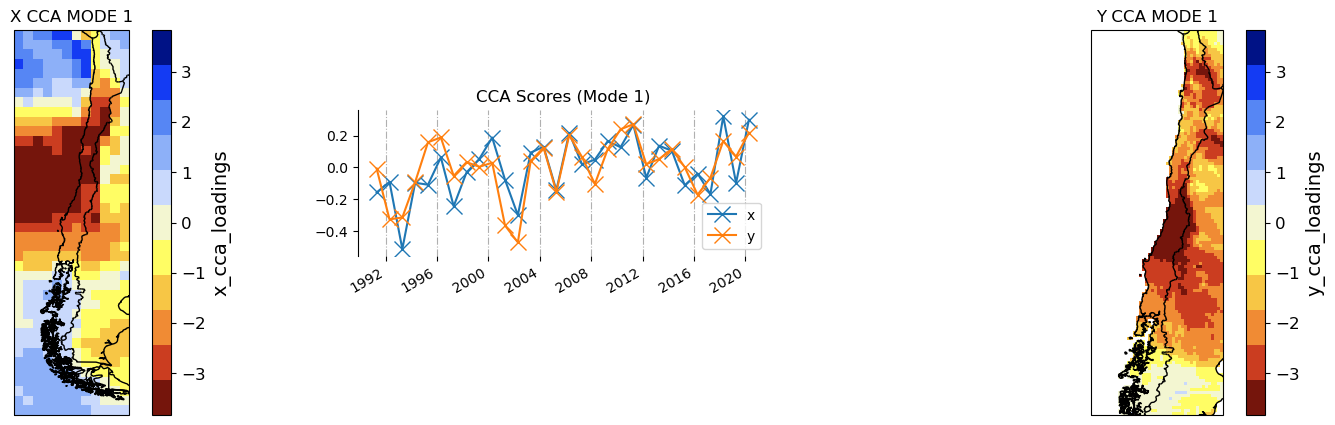

SPEAR.PRCP: CCA MODE 2 - Canonical Correlation = 0.64


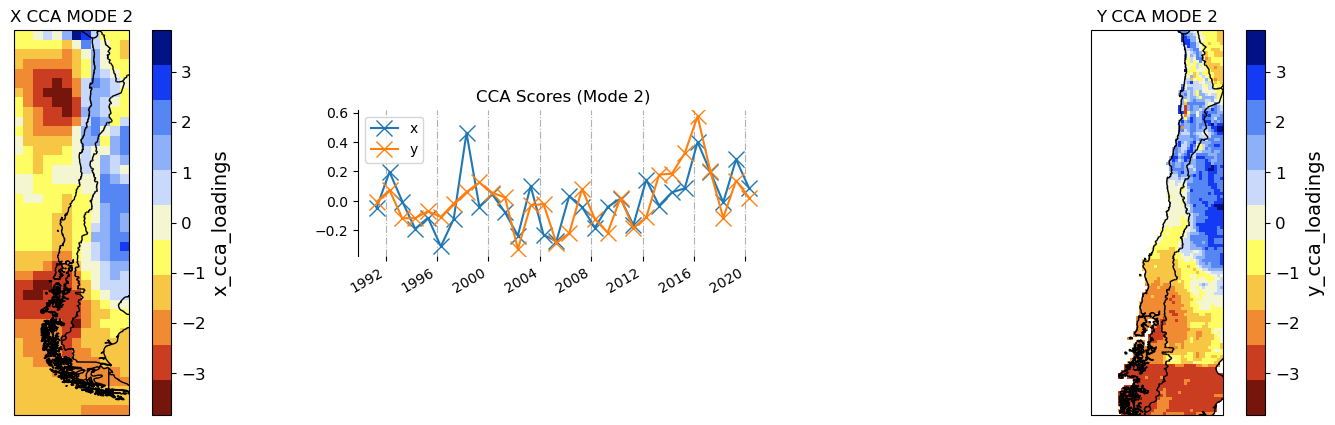

SPEAR.PRCP: CCA MODE 3 - Canonical Correlation = nan


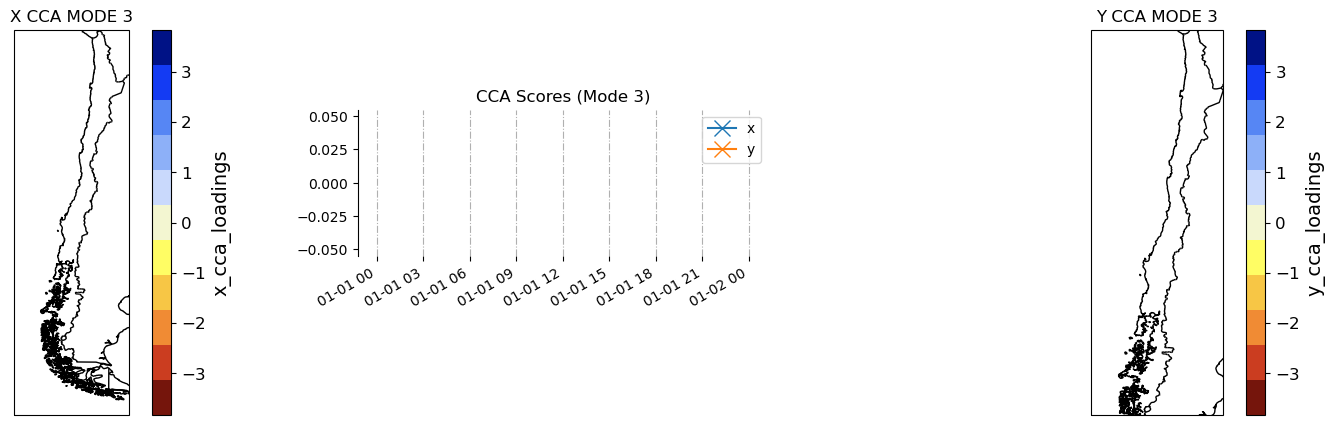

CCSM4.PRCP: CCA MODE 1 - Canonical Correlation = 0.65


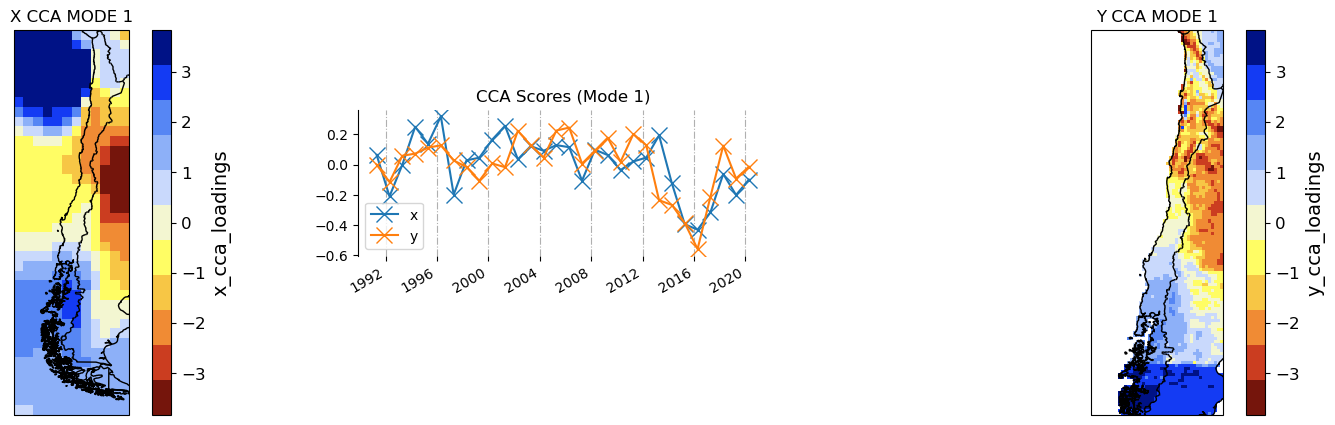

CCSM4.PRCP: CCA MODE 2 - Canonical Correlation = 0.61


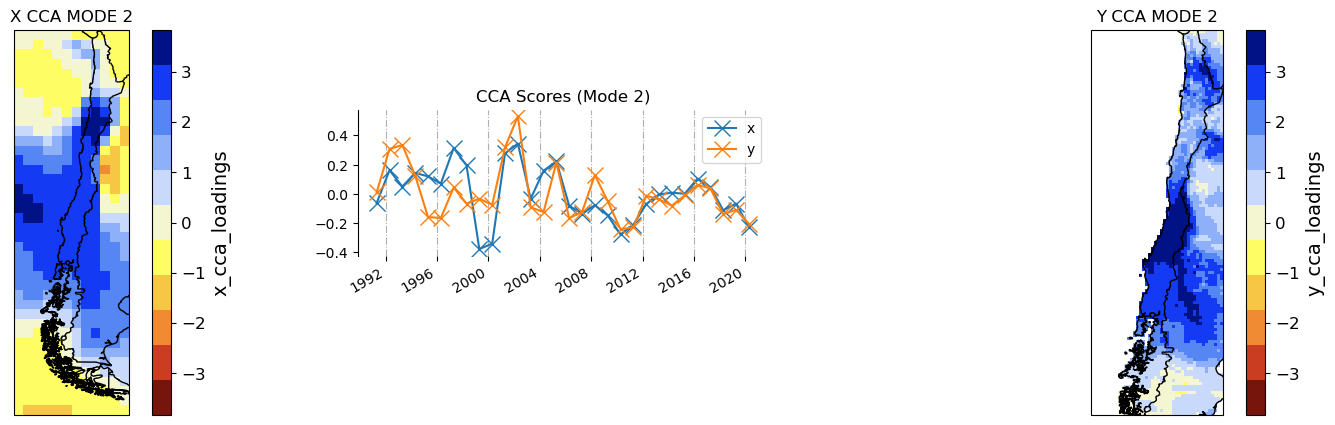

CCSM4.PRCP: CCA MODE 3 - Canonical Correlation = 0.35


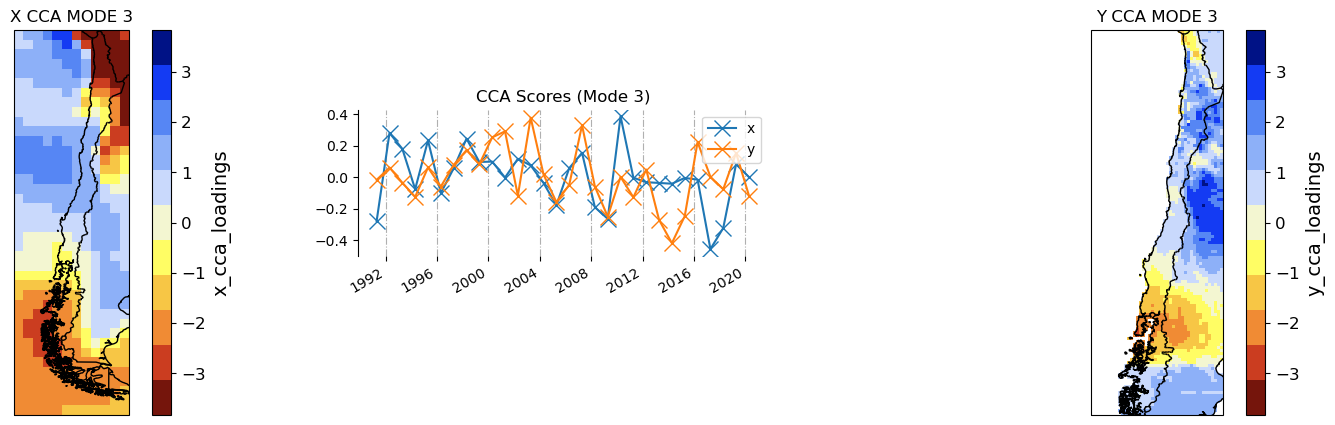

CANSIPSIC3.PRCP: CCA MODE 1 - Canonical Correlation = 0.9


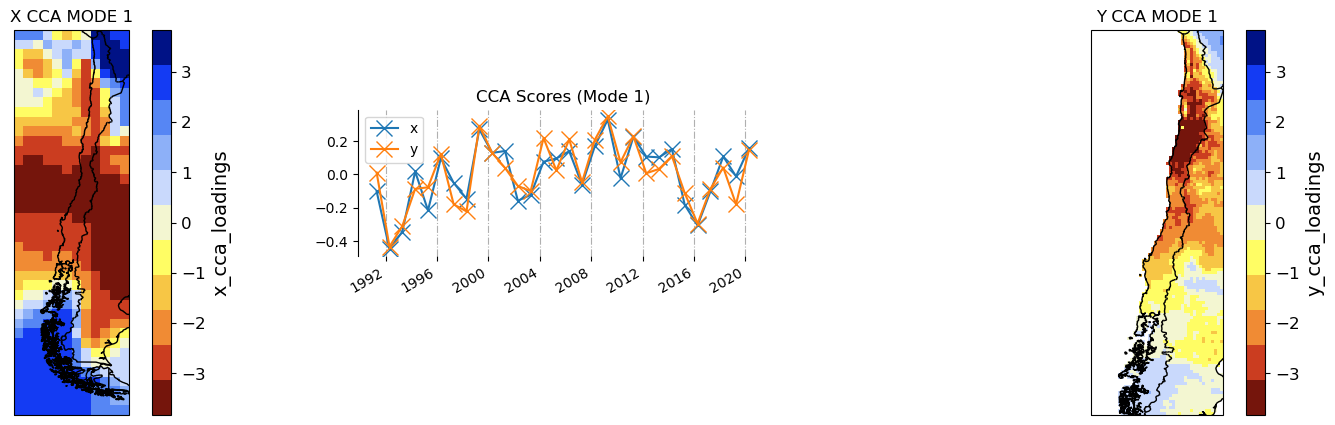

CANSIPSIC3.PRCP: CCA MODE 2 - Canonical Correlation = 0.52


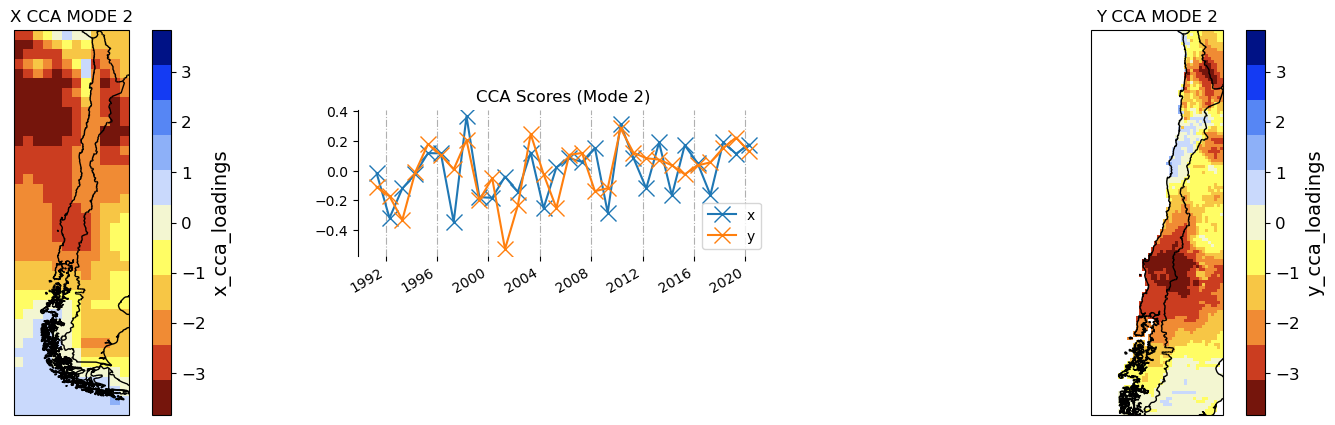

CANSIPSIC3.PRCP: CCA MODE 3 - Canonical Correlation = 0.43


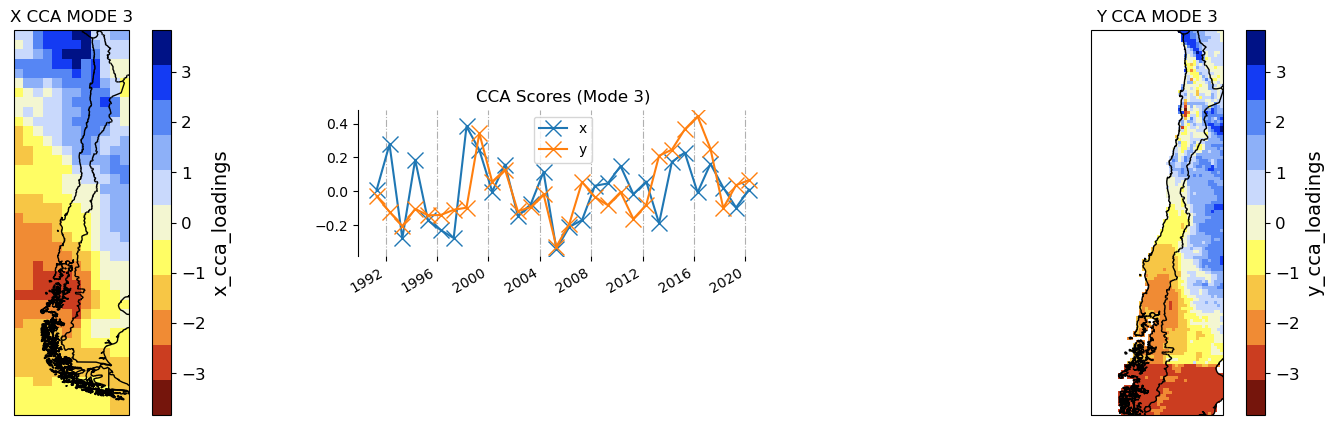

CFSV2.PRCP: CCA MODE 1 - Canonical Correlation = 0.83


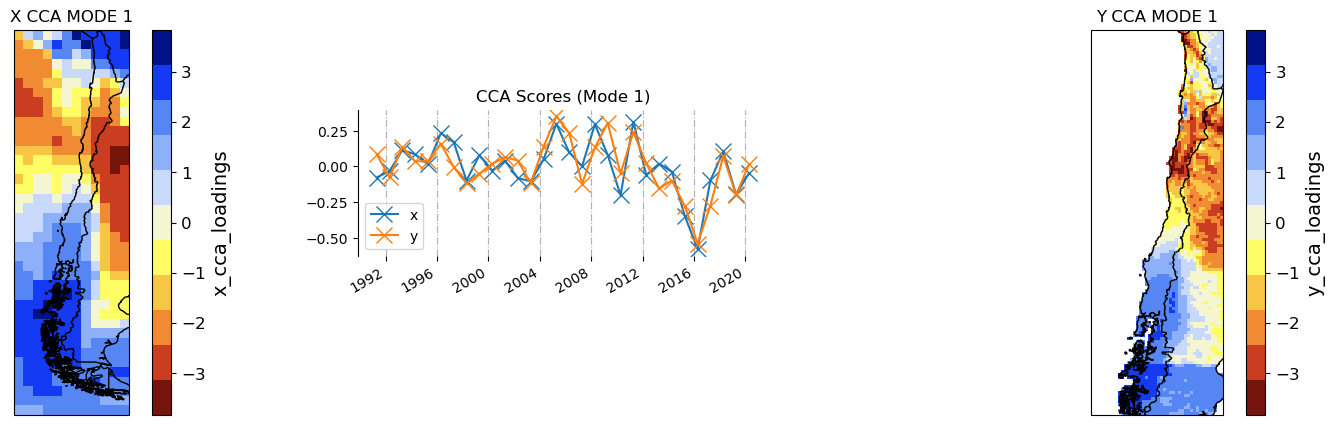

CFSV2.PRCP: CCA MODE 2 - Canonical Correlation = 0.73


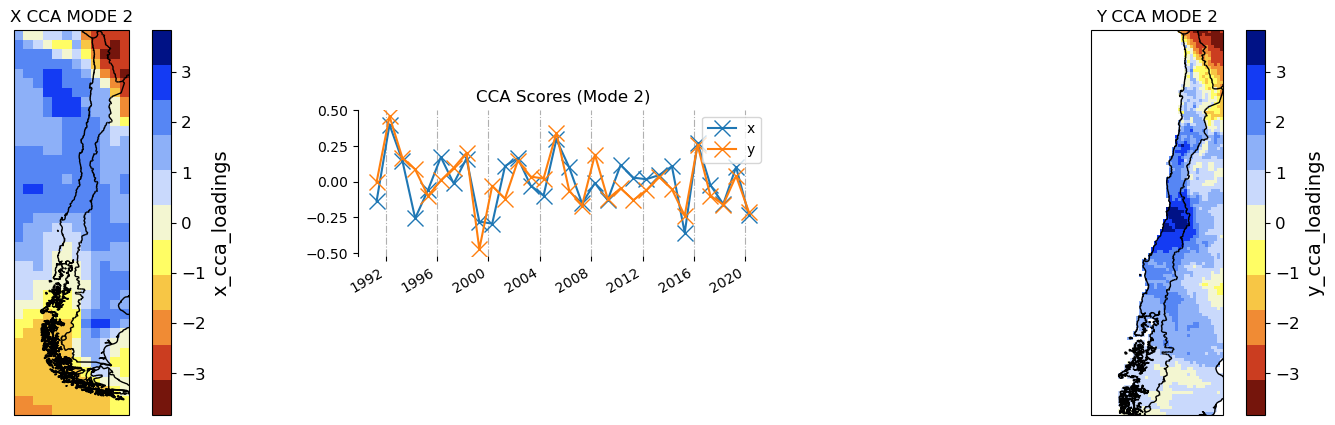

CFSV2.PRCP: CCA MODE 3 - Canonical Correlation = 0.64


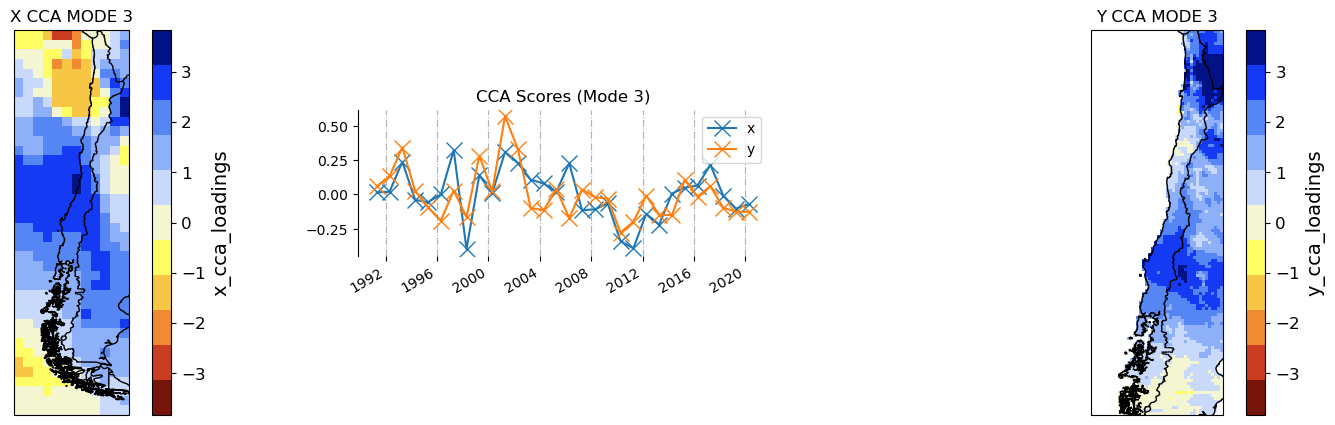

GEOSS2S.PRCP: CCA MODE 1 - Canonical Correlation = 0.79


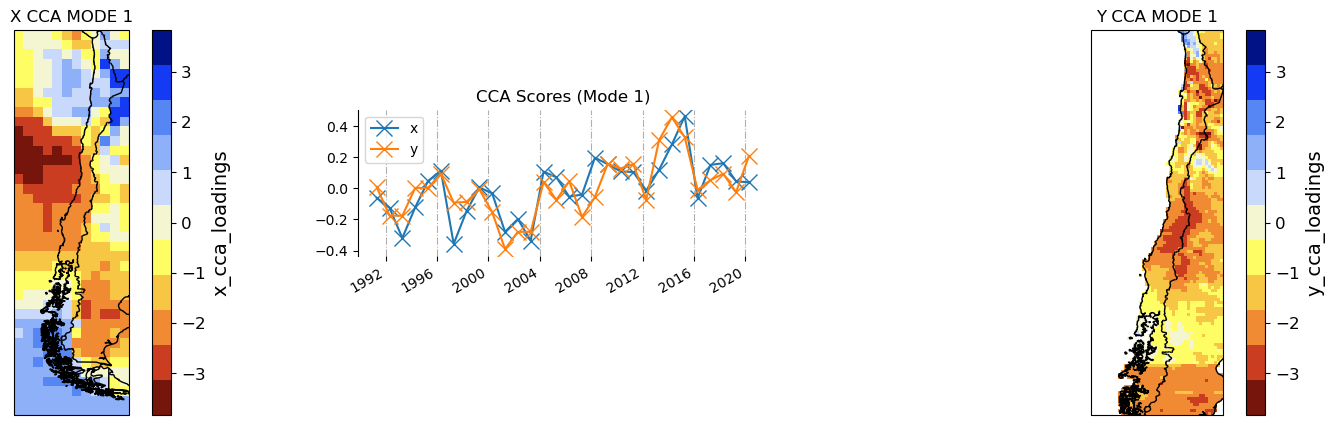

GEOSS2S.PRCP: CCA MODE 2 - Canonical Correlation = 0.55


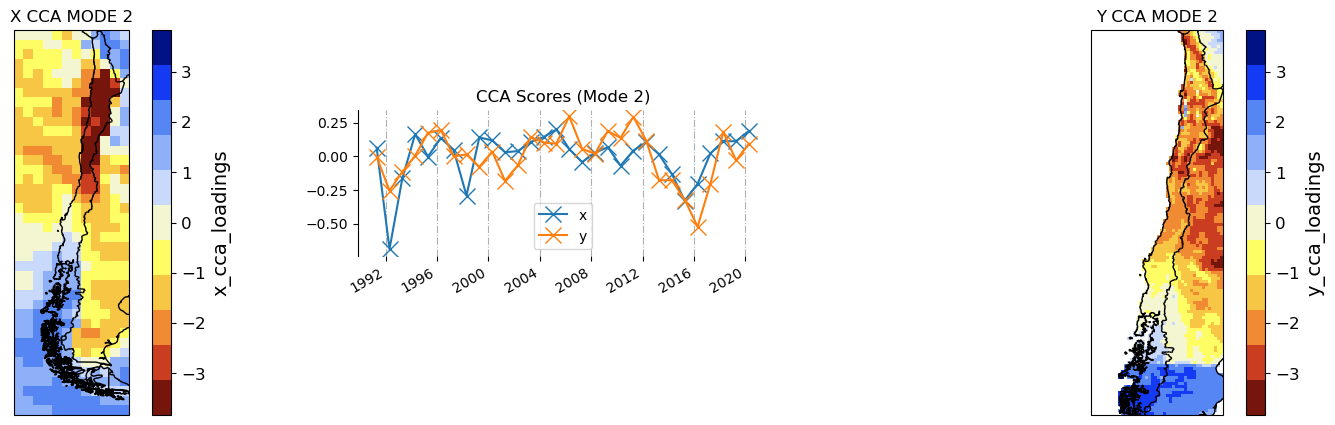

GEOSS2S.PRCP: CCA MODE 3 - Canonical Correlation = 0.42


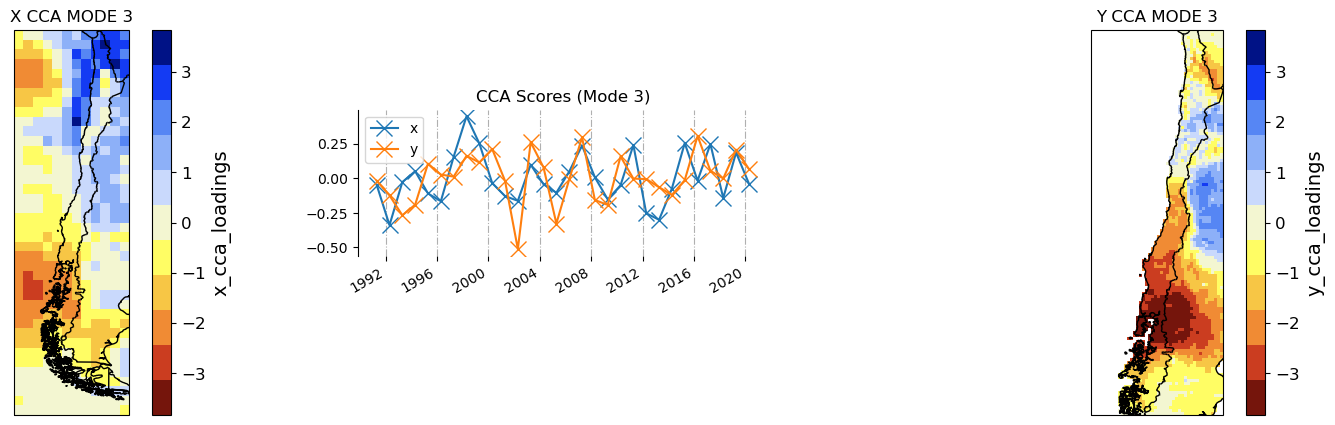

In [13]:
pycpt.plot_cca_modes(MOS, predictor_names, pxs, pys, domain_dir)

#### Plot Forecasts

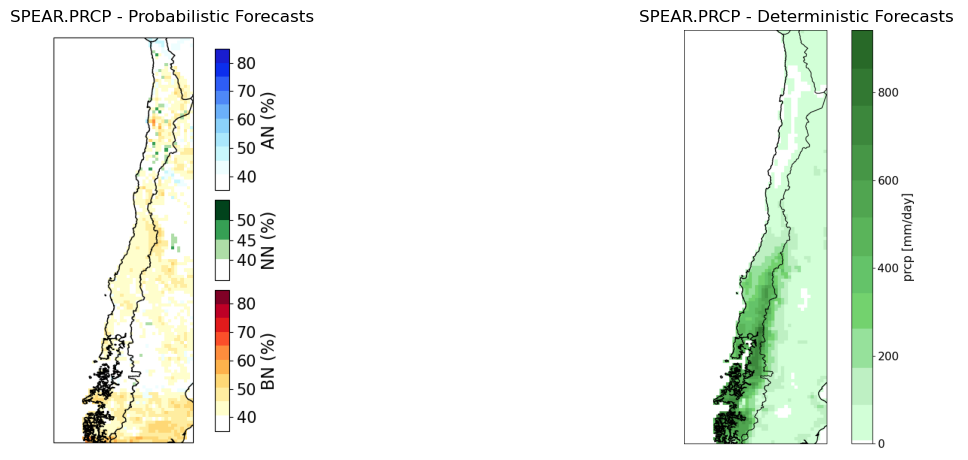

<Figure size 700x700 with 0 Axes>

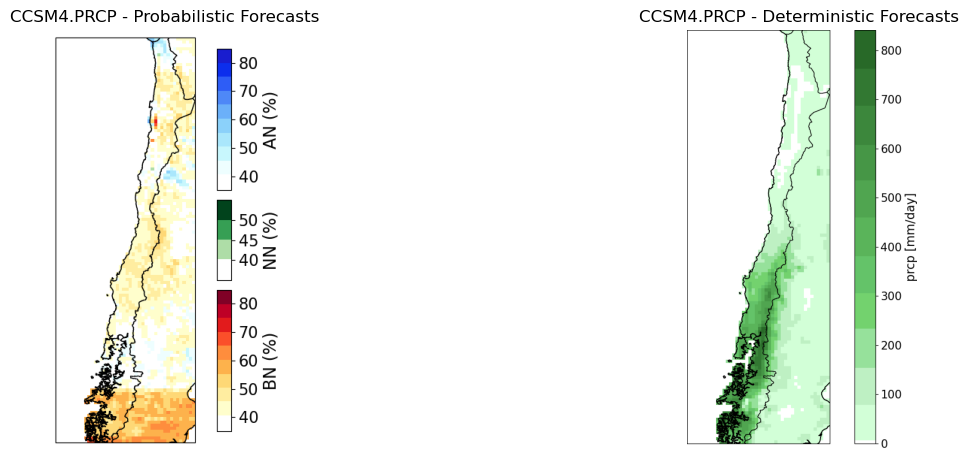

<Figure size 700x700 with 0 Axes>

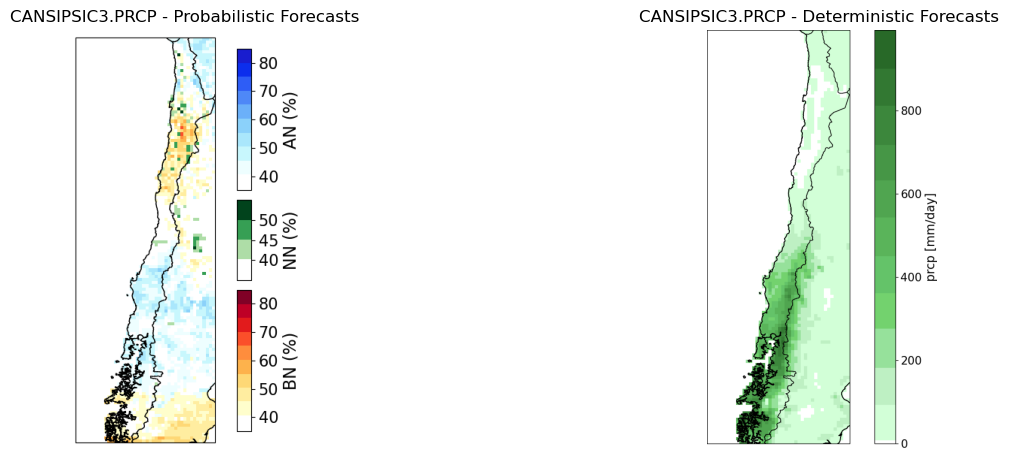

<Figure size 700x700 with 0 Axes>

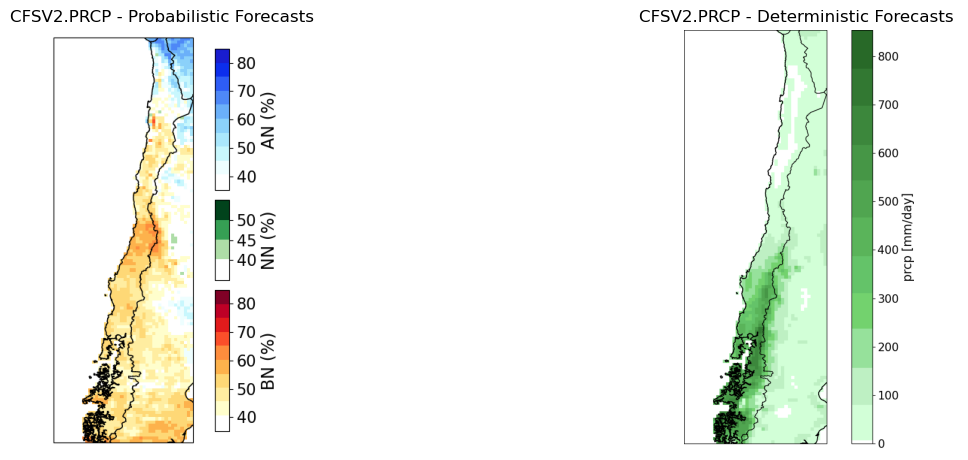

<Figure size 700x700 with 0 Axes>

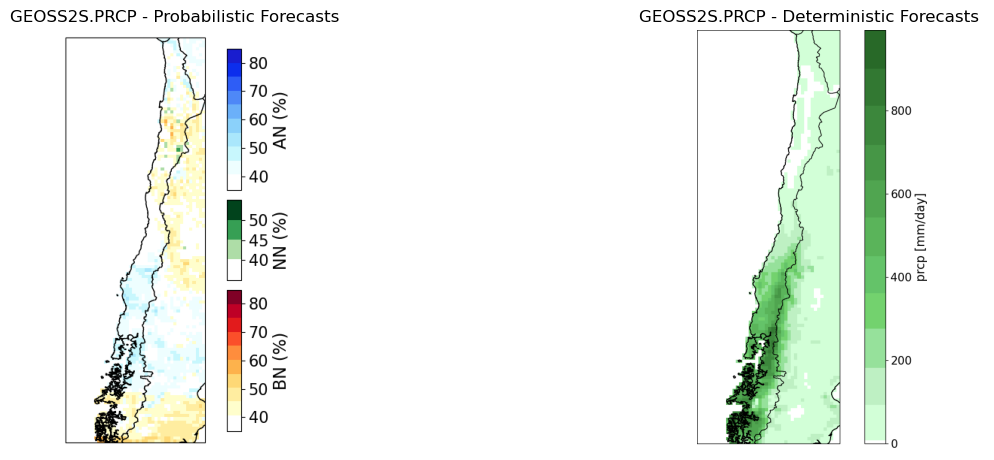

<Figure size 700x700 with 0 Axes>

In [14]:
pycpt.plot_forecasts(cpt_args, predictand_name, fcsts, domain_dir, predictor_names, MOS)

# Multi-Model Ensemble

Choose which models to include in the MME, e.g.
```
ensemble = ['CFSv2.PRCP','SEAS5.PRCP']
```

In [15]:
ensemble = predictor_names

In [16]:
det_fcst, pr_fcst, pev_fcst, nextgen_skill = pycpt.construct_mme(fcsts, hcsts, Y, ensemble, predictor_names, cpt_args, domain_dir)

#### Plot MME Forecast Skill

Deterministic metrics: pearson, spearman, 2afc, roc_below, roc_above

Probabilistic metrics: generalized_roc, rank_probability_skill_score 

e.g.
```
skill_metrics = ["spearman", "generalized_roc"]
```

In [17]:
skill_metrics = [
    "spearman",
    "2afc",
    "generalized_roc",
    "rank_probability_skill_score",
]

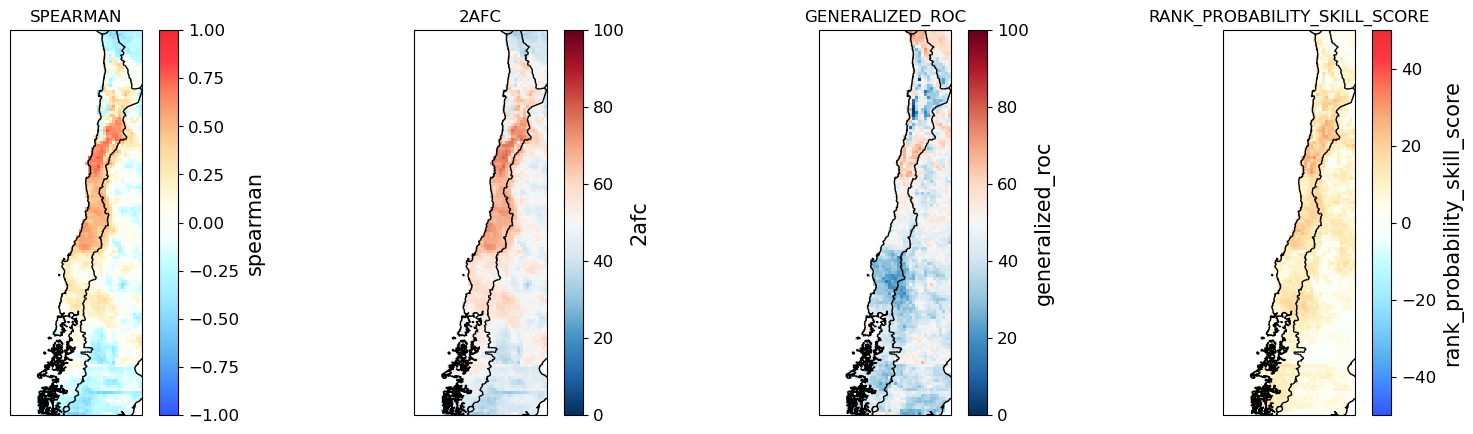

In [18]:
pycpt.plot_mme_skill(predictor_names, nextgen_skill, MOS, domain_dir, skill_metrics)

#### Plot MME Forecasts

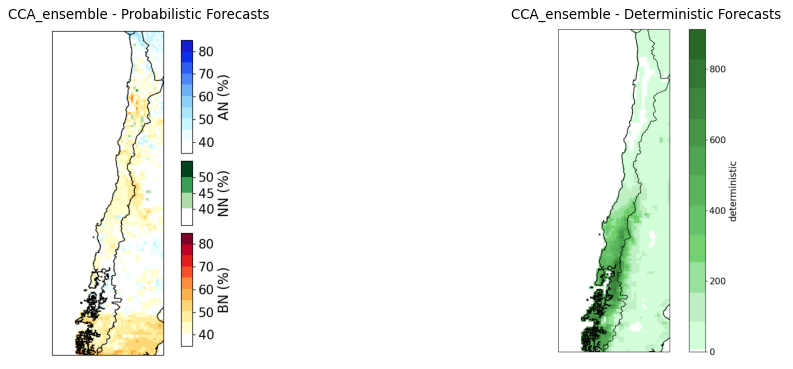

<Figure size 700x700 with 0 Axes>

In [19]:
pycpt.plot_mme_forecasts(cpt_args, predictand_name, pr_fcst, MOS, domain_dir, det_fcst)

#### Construct MME Flexible Forecasts (full PDF)

If `isPercentile` is `True`, the threshold is a percentile (e.g., 0.5)
else in the unit of the predictand (e.g., mm, degC, ...)

In [20]:
threshold = 0.5
isPercentile = True


In [21]:
exceedance_prob, fcst_scale, climo_scale, fcst_mu, climo_mu, Y2, ntrain, transformed_threshold = pycpt.construct_flex_fcst(MOS, cpt_args, det_fcst, threshold, isPercentile, Y, pev_fcst)

/Users/xandre/opt/anaconda3/envs/pycpt_environment/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


#### Plot Flexible MME Forecasts

Choose a gridpoint within the predictand domain to plot the forecast and climatological probability of exceedance and PDF curves. If set to None, the centroid of the predictand domain will be used.

In [26]:
point_latitude = None
point_longitude = None
color_bar='DL_CORRELATION_COLORMAP'

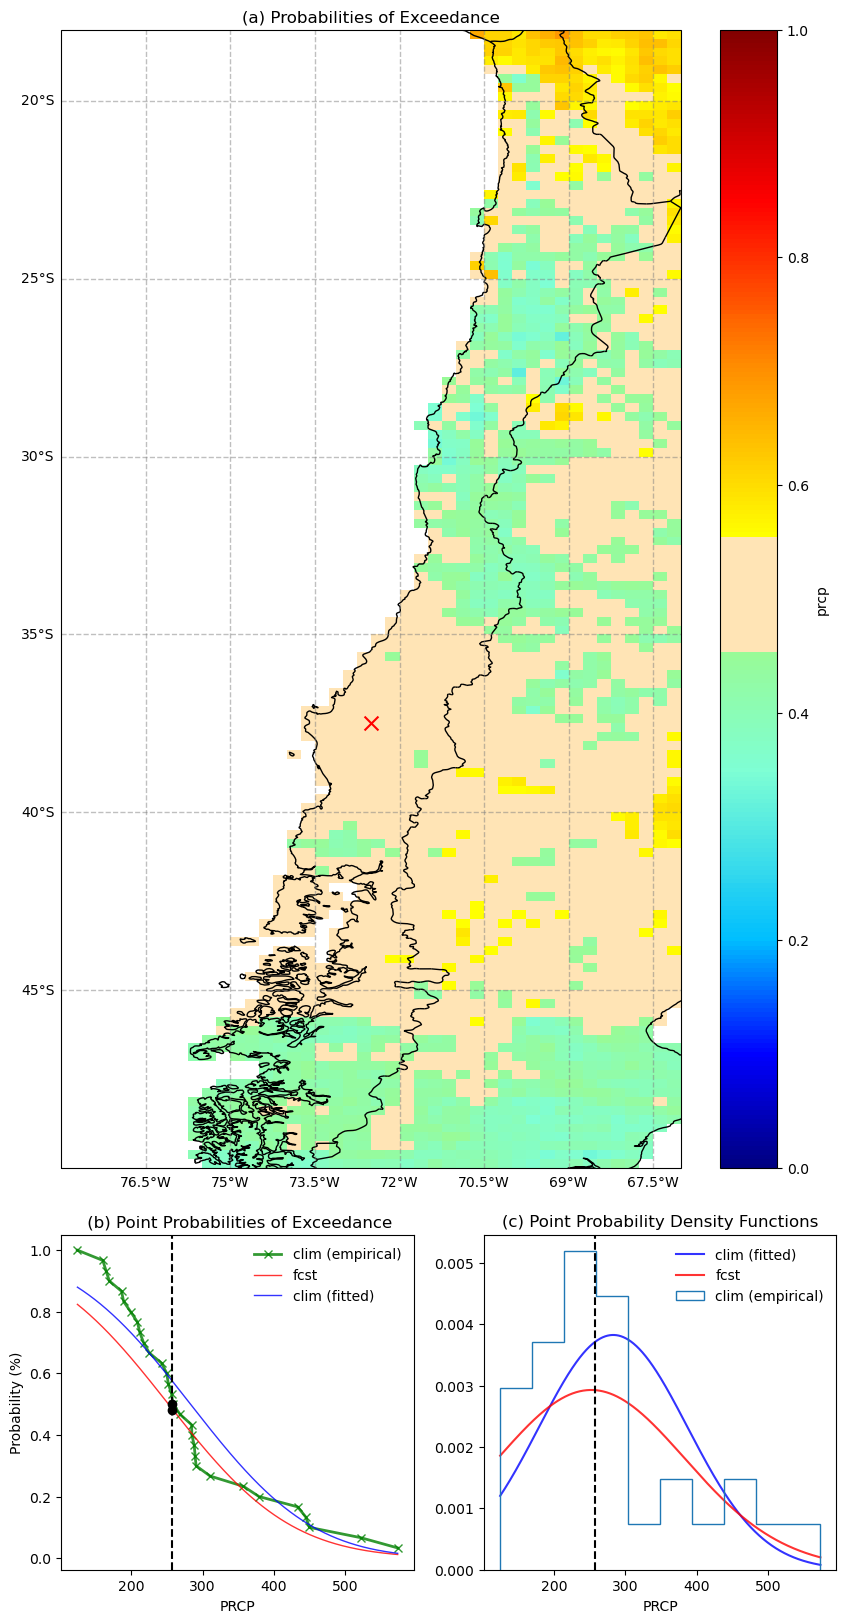

In [27]:
pycpt.plot_mme_flex_forecasts(predictand_name, exceedance_prob, point_latitude, point_longitude, download_args["predictand_extent"], transformed_threshold, fcst_scale, climo_scale, fcst_mu, climo_mu, Y2, cpt_args['transform_predictand'], ntrain, Y, MOS, domain_dir,color_bar)